# Generative Modeling of Stellar Evolution Tracks


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
from tensorflow.keras import backend
import os
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. Data Loading and Exploration


In [2]:
# Load the HYG database
df = pd.read_csv('../hyg_v42.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (119626, 37)

Column names:
['id', 'hip', 'hd', 'hr', 'gl', 'bf', 'proper', 'ra', 'dec', 'dist', 'pmra', 'pmdec', 'rv', 'mag', 'absmag', 'spect', 'ci', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'rarad', 'decrad', 'pmrarad', 'pmdecrad', 'bayer', 'flam', 'con', 'comp', 'comp_primary', 'base', 'lum', 'var', 'var_min', 'var_max']

First few rows:


,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,1,0,NaN,1.000000,NaN,NaN,NaN
1,1,1.0,224700.0,NaN,NaN,NaN,NaN,0.000060,1.089009,219.7802,...,NaN,NaN,Psc,1,1,NaN,9.638290,NaN,NaN,NaN
2,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,...,NaN,NaN,Cet,1,2,NaN,0.392283,NaN,NaN,NaN
3,3,3.0,224699.0,NaN,NaN,NaN,NaN,0.000335,38.859279,442.4779,...,NaN,NaN,And,1,3,NaN,386.901132,NaN,NaN,NaN
4,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,...,NaN,NaN,Phe,1,4,NaN,9.366989,NaN,NaN,NaN


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

Missing values per column:
proper          119127
base            118540
bayer           118089
flam            116889
bf              116527
gl              115825
var             113634
hr              110585
var_max         102635
var_min         102635
hd               20741
spect             3048
ci                1891
hip               1675
con                  1
pmrarad              0
pmdecrad             0
comp_primary         0
comp                 0
rarad                0
dtype: int64


In [4]:
# Select relevant columns for stellar evolution analysis
relevant_columns = [
    'mag', 'absmag', 'ci', 'spect', 'dist', 'x', 'y', 'z', 
    'lum', 'var', 'var_min', 'var_max'
]

# Create a copy with only relevant columns
df_filtered = df[relevant_columns].copy()

# Display missing values in our filtered dataset
print("Missing values in filtered dataset:")
df_filtered.isnull().sum().sort_values(ascending=False)

Missing values in filtered dataset:


var        113634
var_min    102635
var_max    102635
spect        3048
ci           1891
mag             0
absmag          0
dist            0
x               0
y               0
z               0
lum             0
dtype: int64

In [5]:
# Handle missing values strategically

# For critical features, we'll use imputation
critical_features = ['absmag', 'ci', 'lum', 'dist']

# Create a subset with only critical features for initial analysis
df_critical = df_filtered[critical_features].copy()

# # Impute missing values in ci (color index) with median
# ci_imputer = SimpleImputer(strategy='median')
# df_critical['ci'] = ci_imputer.fit_transform(df_critical[['ci']])

# Check if we still have missing values
print("Missing values after initial imputation:")
print(df_critical.isnull().sum())

# Create a clean dataset without any missing values
df_clean = df_critical.dropna()

print(f"Clean dataset shape: {df_clean.shape}")

Missing values after initial imputation:
absmag       0
ci        1891
lum          0
dist         0
dtype: int64
Clean dataset shape: (117735, 4)


In [6]:
# Basic statistics of the filtered dataset
df_filtered.describe()

,mag,absmag,ci,dist,x,y,z,lum,var_min,var_max
count,119626.000000,119626.000000,117735.000000,119626.000000,119626.000000,119626.000000,119626.000000,1.196260e+05,16991.000000,16991.000000
mean,8.429465,0.990741,0.711516,8772.285030,-235.250971,-39.324238,-235.029843,3.565260e+05,9.501549,9.258892
std,1.427752,4.353396,0.493218,27890.666828,15182.707650,17248.951976,18074.563273,3.341375e+06,1.781276,1.742416
min,-26.700000,-16.680000,-0.400000,0.000000,-99950.391271,-99979.246192,-99964.982269,1.225745e-06,-1.333000,-1.523000
25%,7.650000,0.138000,0.348500,115.074800,-89.043152,-91.176368,-107.566739,4.746790e+00,8.525500,8.243000
50%,8.460000,1.495000,0.616000,213.675200,-1.050364,-1.238857,-3.415646,2.197860e+01,9.849000,9.646000
75%,9.170000,3.159000,1.083000,392.156900,86.267843,91.872584,94.974160,7.670082e+01,10.707000,10.492000
max,21.000000,19.629000,5.460000,100000.000000,99982.372691,99996.065513,99862.513669,4.092607e+08,14.902000,13.702000


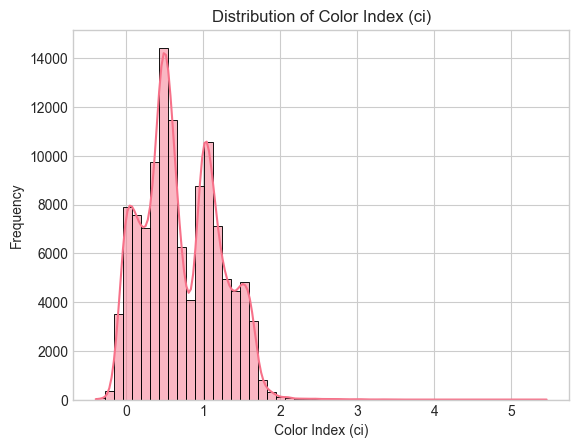

In [7]:
sns.histplot(df_filtered['ci'].dropna(), bins=50, kde=True)
plt.title('Distribution of Color Index (ci)')
plt.xlabel('Color Index (ci)')
plt.ylabel('Frequency')
plt.show()

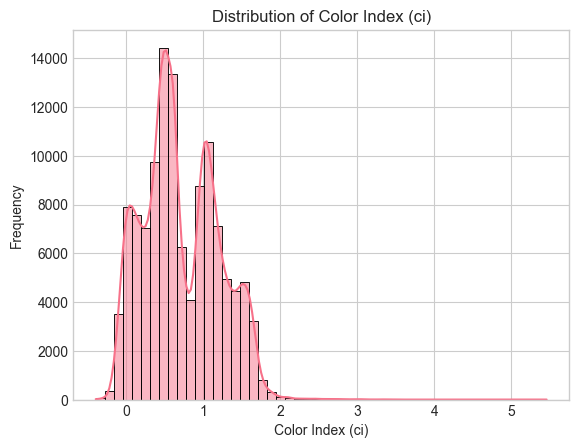

In [8]:
sns.histplot(df_filtered['ci'].fillna(df_filtered['ci'].median()), bins=50, kde=True)
plt.title('Distribution of Color Index (ci)')
plt.xlabel('Color Index (ci)')
plt.ylabel('Frequency')
plt.show()

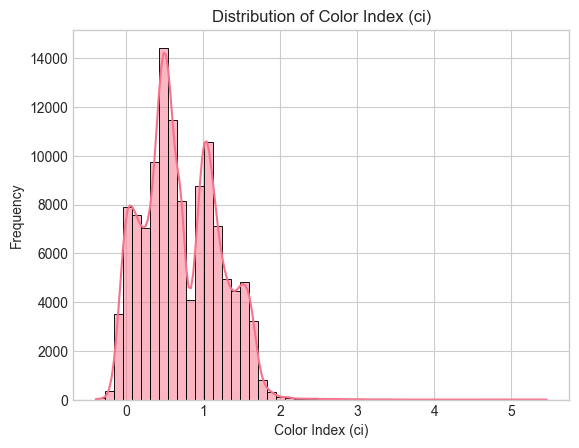

In [9]:
sns.histplot(df_filtered['ci'].fillna(df_filtered['ci'].mean()), bins=50, kde=True)
plt.title('Distribution of Color Index (ci)')
plt.xlabel('Color Index (ci)')
plt.ylabel('Frequency')
plt.show()

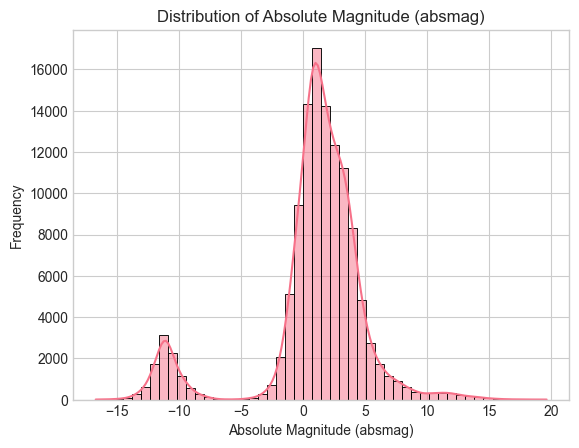

In [10]:
sns.histplot(df_filtered['absmag'].dropna(), bins=50, kde=True)
plt.title('Distribution of Absolute Magnitude (absmag)')
plt.xlabel('Absolute Magnitude (absmag)')
plt.ylabel('Frequency')
plt.show()

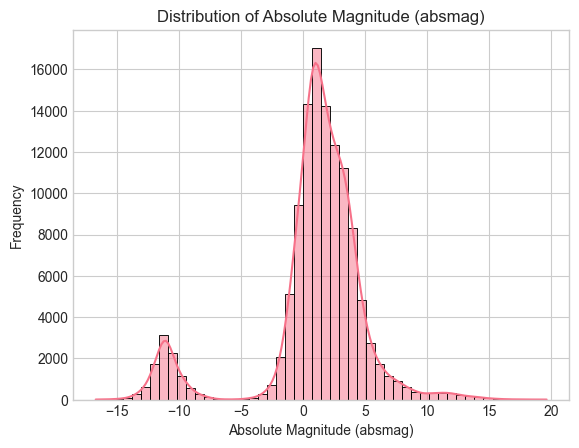

In [11]:
sns.histplot(df_filtered['absmag'].fillna(df_filtered['absmag'].median()), bins=50, kde=True)
plt.title('Distribution of Absolute Magnitude (absmag)')
plt.xlabel('Absolute Magnitude (absmag)')
plt.ylabel('Frequency')
plt.show()

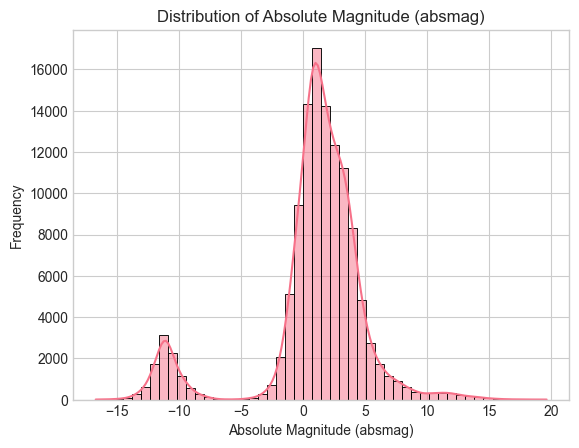

In [12]:
sns.histplot(df_filtered['absmag'].fillna(df_filtered['absmag'].mean()), bins=50, kde=True)
plt.title('Distribution of Absolute Magnitude (absmag)')
plt.xlabel('Absolute Magnitude (absmag)')
plt.ylabel('Frequency')
plt.show()

## 2. Data Preprocessing

df_filtered shape: (119626, 12)
Missing values in ci: 1891
Missing values in absmag: 0


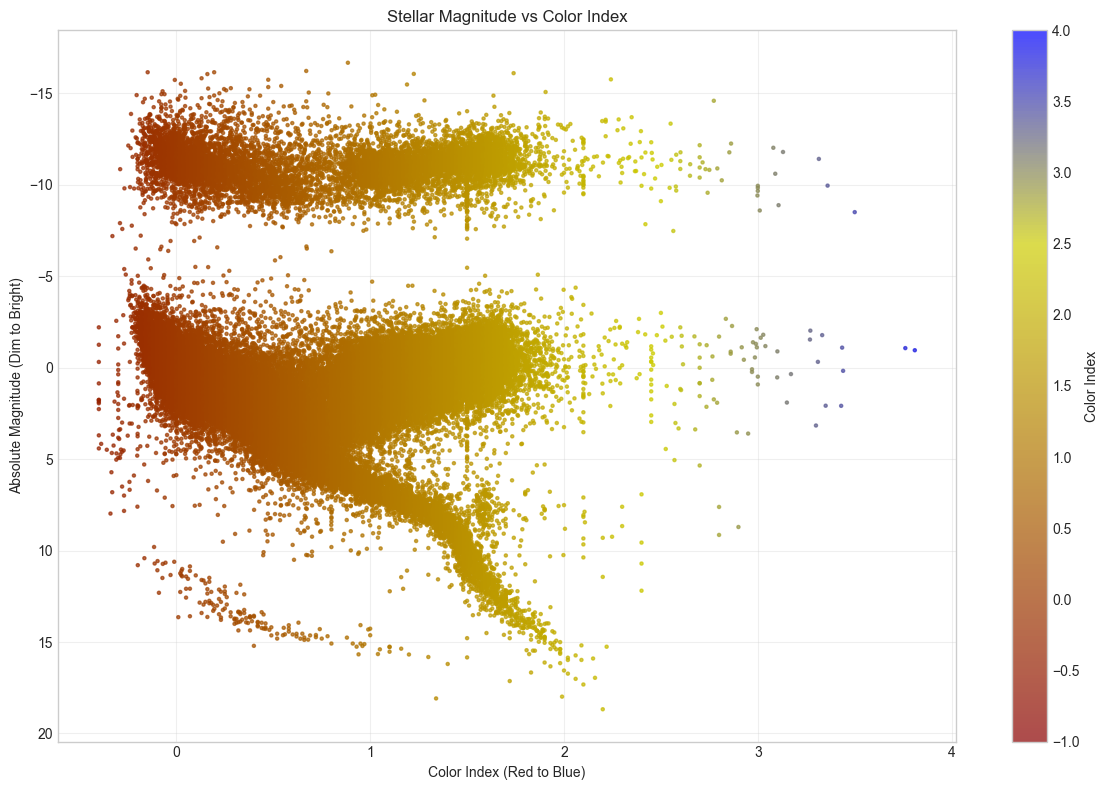

In [13]:
# Now let's create the interactive plot
import plotly.express as px
import matplotlib.colors as mcolors
import numpy as np

# Check if we have the required data
print(f"df_filtered shape: {df_filtered.shape}")
print(f"Missing values in ci: {df_filtered['ci'].isnull().sum()}")
print(f"Missing values in absmag: {df_filtered['absmag'].isnull().sum()}")

# Handle missing values for the visualization - PROPERLY
df_viz = df_filtered.dropna(subset=['ci', 'absmag']).copy()

# REMOVE or WIDEN the restrictive ci filter that's causing the gap
# Allow negative color indices (hot, blue stars)
df_viz = df_viz[(df_viz['ci'] >= -1.0) & (df_viz['ci'] <= 4.0)]  # More inclusive range

# Create a custom colormap that matches your R code
red4 = (139/255, 0, 0)        # #8B0000
yellow3 = (205/255, 205/255, 0)  # #CDCD00
blue = (0, 0, 1)              # #0000FF

# Create a custom colormap that matches your R code
colors = [red4, yellow3, blue]
positions = [0.0, 0.7, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_r_gradient", list(zip(positions, colors)))

# Create the plot with the custom color gradient
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_viz['ci'], df_viz['absmag'], 
                      c=df_viz['ci'], cmap=custom_cmap, 
                      alpha=0.7, s=5, vmin=-1.0, vmax=4.0)  # Update vmin/vmax

# Add colorbar
cbar = plt.colorbar(scatter, label='Color Index')
cbar.set_ticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])

# Set labels with the specific formatting from your R code
plt.xlabel('Color Index (Red to Blue)')
plt.ylabel('Absolute Magnitude (Dim to Bright)')
plt.title('Stellar Magnitude vs Color Index')

# Invert y-axis as per HR convention
plt.gca().invert_yaxis()

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Filter out extreme outliers
df_clean = df_filtered[
    (df_filtered['ci'] > -0.5) & (df_filtered['ci'] < 2.5) &
    (df_filtered['absmag'] > -5) & (df_filtered['absmag'] < 15) &
    (df_filtered['lum'] > 0.001) & (df_filtered['lum'] < 1000000)
].copy()

print(f"Cleaned dataset shape: {df_clean.shape}")

Cleaned dataset shape: (107368, 12)


In [15]:
# Apply log transformation to luminosity to handle large range
df_clean['log_lum'] = np.log10(df_clean['lum'] + 1e-10)

# Select features for the generative model
features = ['ci', 'absmag', 'log_lum', 'dist']
df_features = df_clean[features].dropna()

print(f"Final dataset for modeling: {df_features.shape}")

Final dataset for modeling: (107368, 4)


In [16]:
df_features

,ci,absmag,log_lum,dist
0,0.656,4.850,4.342945e-11,0.0000
1,0.482,2.390,9.840000e-01,219.7802
2,0.999,5.866,-4.064000e-01,47.9616
3,-0.019,-1.619,2.587600e+00,442.4779
4,0.370,2.421,9.716000e-01,134.2282
...,...,...,...,...
119604,1.540,11.010,-2.464000e+00,13.8696
119608,1.640,11.482,-2.652800e+00,18.5185
119611,1.690,11.260,-2.564000e+00,7.6336
119612,1.450,11.100,-2.498667e+00,15.8730


In [17]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

# Create a new DataFrame with scaled features
df_scaled = pd.DataFrame(scaled_features, columns=features)
df_scaled.head()

,ci,absmag,log_lum,dist
0,-0.087162,1.315505,-1.315505,-1.308336
1,-0.456446,0.186458,-0.186458,-0.150054
2,0.640795,1.781811,-1.781811,-1.055570
3,-1.519730,-1.653522,1.653522,1.023604
4,-0.694146,0.200686,-0.200686,-0.600929


## 3. Dimensionality Reduction with PCA


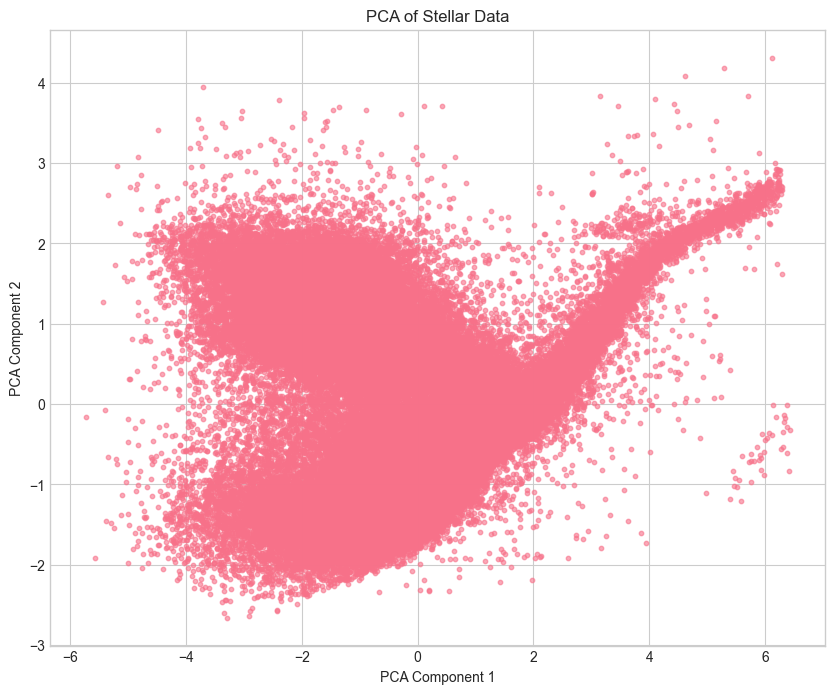

Explained variance ratio: [0.64870165 0.25530201]


In [18]:
# Apply PCA to visualize the data structure
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Stellar Data')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

## 4. Variational Autoencoder (VAE) Implementation


In [19]:
# Define the VAE architecture
class VAE(keras.Model):
    def __init__(self, latent_dim, input_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        
        # Encoder
        self.encoder = keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim * 2)  # Mean and variance
        ])
        
        # Decoder
        self.decoder = keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation='linear')
        ])
    
    def encode(self, x):
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean
    
    def decode(self, z):
        return self.decoder(z)
    
    def call(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, log_var

# Define the loss function - FIXED
def vae_loss(x, x_reconstructed, mean, log_var):
    # Reconstruction loss (MSE)
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_reconstructed))
    
    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    
    return reconstruction_loss + kl_loss


In [25]:
# Prepare training data
X_train = df_scaled.values.astype(np.float32)

# Initialize and compile the VAE
latent_dim = 2
input_dim = X_train.shape[1]

vae = VAE(latent_dim, input_dim)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Custom learning rate scheduler
class CustomLRScheduler:
    def __init__(self, optimizer, factor=0.5, patience=10, min_lr=1e-6):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_loss = float('inf')
        self.wait = 0
        self.lr_history = []
        
    def on_epoch_end(self, epoch, loss):
        current_lr = float(self.optimizer.learning_rate.numpy())
        self.lr_history.append(current_lr)
        
        if loss < self.best_loss:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(current_lr * self.factor, self.min_lr)
                if new_lr < current_lr:
                    self.optimizer.learning_rate.assign(new_lr)
                    print(f"Reducing learning rate to {new_lr:.2e}")
                    self.wait = 0

# Custom early stopping
class CustomEarlyStopping:
    def __init__(self, patience=100, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None
        
    def on_epoch_end(self, epoch, loss, model):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
            self.best_weights = model.get_weights()
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.stopped_epoch = epoch
            if self.best_weights is not None:
                model.set_weights(self.best_weights)
            return True
        return False

# Initialize custom callbacks
lr_scheduler = CustomLRScheduler(optimizer, factor=0.5, patience=50, min_lr=1e-6)
early_stopping = CustomEarlyStopping(patience=150)

# Training function
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, log_var = vae(x)
        loss = vae_loss(x, x_reconstructed, mean, log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Training loop with custom callbacks
epochs = 1000
batch_size = 16
num_batches = int(np.ceil(X_train.shape[0] / batch_size))

loss_history = []
lr_history = []
previous_loss = float('inf')

for epoch in range(epochs):
    epoch_loss = 0
    # Shuffle data
    np.random.shuffle(X_train)
    
    for batch in tqdm(range(num_batches), desc="Training Epoch {}".format(epoch+1)):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, X_train.shape[0])
        x_batch = X_train[start_idx:end_idx]
        
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()
    
    epoch_loss /= num_batches
    loss_history.append(epoch_loss)
    
    # Update learning rate based on custom scheduler
    lr_scheduler.on_epoch_end(epoch, epoch_loss)
    current_lr = float(optimizer.learning_rate.numpy())
    lr_history.append(current_lr)
    
    # Save model checkpoint every 50 epochs
    if previous_loss > epoch_loss:
        checkpoint_dir = 'model_checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f'best_vae_weights.weights.h5')
        vae.save_weights(checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")
        previous_loss = epoch_loss

    # Check for early stopping
    if early_stopping.on_epoch_end(epoch, epoch_loss, vae):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}")

print("Training completed!")

# Save the final model
os.makedirs('Models', exist_ok=True)
vae.load_weights(checkpoint_path)  # Load best weights before saving final model
vae.save_weights('Models/stellar_vae_weights_final.weights.h5')
print("Final model saved!")

Training Epoch 1: 100%|██████████| 6711/6711 [00:09<00:00, 696.53it/s] 


Checkpoint saved at epoch 1
Epoch 0, Loss: 0.8050, LR: 0.001000


Training Epoch 2: 100%|██████████| 6711/6711 [00:08<00:00, 810.30it/s] 


Checkpoint saved at epoch 2
Epoch 1, Loss: 0.7965, LR: 0.001000


Training Epoch 3: 100%|██████████| 6711/6711 [00:12<00:00, 529.65it/s]


Epoch 2, Loss: 0.7968, LR: 0.001000


Training Epoch 4: 100%|██████████| 6711/6711 [00:12<00:00, 537.97it/s]


Checkpoint saved at epoch 4
Epoch 3, Loss: 0.7924, LR: 0.001000


Training Epoch 5: 100%|██████████| 6711/6711 [00:11<00:00, 569.00it/s]


Epoch 4, Loss: 0.7963, LR: 0.001000


Training Epoch 6: 100%|██████████| 6711/6711 [00:13<00:00, 515.53it/s]


Epoch 5, Loss: 0.7940, LR: 0.001000


Training Epoch 7: 100%|██████████| 6711/6711 [00:12<00:00, 542.09it/s]


Epoch 6, Loss: 0.7953, LR: 0.001000


Training Epoch 8: 100%|██████████| 6711/6711 [00:13<00:00, 497.46it/s]


Epoch 7, Loss: 0.7929, LR: 0.001000


Training Epoch 9: 100%|██████████| 6711/6711 [00:13<00:00, 507.49it/s]


Epoch 8, Loss: 0.7940, LR: 0.001000


Training Epoch 10: 100%|██████████| 6711/6711 [00:13<00:00, 499.99it/s]


Epoch 9, Loss: 0.7946, LR: 0.001000


Training Epoch 11: 100%|██████████| 6711/6711 [00:13<00:00, 497.73it/s]


Epoch 10, Loss: 0.7948, LR: 0.001000


Training Epoch 12: 100%|██████████| 6711/6711 [00:10<00:00, 616.03it/s]


Epoch 11, Loss: 0.7927, LR: 0.001000


Training Epoch 13: 100%|██████████| 6711/6711 [00:12<00:00, 552.13it/s]


Checkpoint saved at epoch 13
Epoch 12, Loss: 0.7920, LR: 0.001000


Training Epoch 14: 100%|██████████| 6711/6711 [00:13<00:00, 484.93it/s]


Checkpoint saved at epoch 14
Epoch 13, Loss: 0.7901, LR: 0.001000


Training Epoch 15: 100%|██████████| 6711/6711 [00:13<00:00, 495.30it/s]


Epoch 14, Loss: 0.7918, LR: 0.001000


Training Epoch 16: 100%|██████████| 6711/6711 [00:13<00:00, 502.65it/s]


Epoch 15, Loss: 0.7915, LR: 0.001000


Training Epoch 17: 100%|██████████| 6711/6711 [00:13<00:00, 515.32it/s]


Epoch 16, Loss: 0.7911, LR: 0.001000


Training Epoch 18: 100%|██████████| 6711/6711 [00:13<00:00, 500.69it/s]


Checkpoint saved at epoch 18
Epoch 17, Loss: 0.7900, LR: 0.001000


Training Epoch 19: 100%|██████████| 6711/6711 [00:13<00:00, 505.62it/s]


Epoch 18, Loss: 0.7914, LR: 0.001000


Training Epoch 20: 100%|██████████| 6711/6711 [00:12<00:00, 548.21it/s]


Epoch 19, Loss: 0.7915, LR: 0.001000


Training Epoch 21: 100%|██████████| 6711/6711 [00:13<00:00, 494.05it/s]


Epoch 20, Loss: 0.7918, LR: 0.001000


Training Epoch 22: 100%|██████████| 6711/6711 [00:13<00:00, 510.14it/s]


Checkpoint saved at epoch 22
Epoch 21, Loss: 0.7900, LR: 0.001000


Training Epoch 23: 100%|██████████| 6711/6711 [00:13<00:00, 491.65it/s]


Epoch 22, Loss: 0.7913, LR: 0.001000


Training Epoch 24: 100%|██████████| 6711/6711 [00:13<00:00, 498.88it/s]


Epoch 23, Loss: 0.7923, LR: 0.001000


Training Epoch 25: 100%|██████████| 6711/6711 [00:12<00:00, 545.68it/s]


Epoch 24, Loss: 0.7918, LR: 0.001000


Training Epoch 26: 100%|██████████| 6711/6711 [00:12<00:00, 532.49it/s]


Epoch 25, Loss: 0.7939, LR: 0.001000


Training Epoch 27: 100%|██████████| 6711/6711 [00:12<00:00, 518.64it/s]


Checkpoint saved at epoch 27
Epoch 26, Loss: 0.7897, LR: 0.001000


Training Epoch 28: 100%|██████████| 6711/6711 [00:12<00:00, 529.81it/s]


Epoch 27, Loss: 0.7904, LR: 0.001000


Training Epoch 29: 100%|██████████| 6711/6711 [00:12<00:00, 546.27it/s]


Epoch 28, Loss: 0.7910, LR: 0.001000


Training Epoch 30: 100%|██████████| 6711/6711 [00:13<00:00, 509.86it/s]


Epoch 29, Loss: 0.7904, LR: 0.001000


Training Epoch 31: 100%|██████████| 6711/6711 [00:13<00:00, 479.39it/s]


Checkpoint saved at epoch 31
Epoch 30, Loss: 0.7889, LR: 0.001000


Training Epoch 32: 100%|██████████| 6711/6711 [00:12<00:00, 540.81it/s]


Epoch 31, Loss: 0.7923, LR: 0.001000


Training Epoch 33: 100%|██████████| 6711/6711 [00:12<00:00, 538.96it/s]


Epoch 32, Loss: 0.7905, LR: 0.001000


Training Epoch 34: 100%|██████████| 6711/6711 [00:13<00:00, 491.74it/s]


Epoch 33, Loss: 0.7918, LR: 0.001000


Training Epoch 35: 100%|██████████| 6711/6711 [00:14<00:00, 473.10it/s]


Epoch 34, Loss: 0.7917, LR: 0.001000


Training Epoch 36: 100%|██████████| 6711/6711 [00:15<00:00, 443.43it/s]


Epoch 35, Loss: 0.7907, LR: 0.001000


Training Epoch 37: 100%|██████████| 6711/6711 [00:16<00:00, 406.42it/s]


Epoch 36, Loss: 0.7914, LR: 0.001000


Training Epoch 38: 100%|██████████| 6711/6711 [00:16<00:00, 404.65it/s]


Epoch 37, Loss: 0.7904, LR: 0.001000


Training Epoch 39: 100%|██████████| 6711/6711 [00:15<00:00, 420.07it/s]


Epoch 38, Loss: 0.7914, LR: 0.001000


Training Epoch 40: 100%|██████████| 6711/6711 [00:15<00:00, 436.50it/s]


Epoch 39, Loss: 0.7921, LR: 0.001000


Training Epoch 41: 100%|██████████| 6711/6711 [00:12<00:00, 540.28it/s]


Checkpoint saved at epoch 41
Epoch 40, Loss: 0.7878, LR: 0.001000


Training Epoch 42: 100%|██████████| 6711/6711 [00:13<00:00, 492.57it/s]


Epoch 41, Loss: 0.7916, LR: 0.001000


Training Epoch 43: 100%|██████████| 6711/6711 [00:14<00:00, 451.32it/s]


Epoch 42, Loss: 0.7922, LR: 0.001000


Training Epoch 44: 100%|██████████| 6711/6711 [00:14<00:00, 447.45it/s]


Epoch 43, Loss: 0.7904, LR: 0.001000


Training Epoch 45: 100%|██████████| 6711/6711 [00:15<00:00, 445.54it/s]


Epoch 44, Loss: 0.7902, LR: 0.001000


Training Epoch 46: 100%|██████████| 6711/6711 [00:15<00:00, 438.35it/s]


Epoch 45, Loss: 0.7904, LR: 0.001000


Training Epoch 47: 100%|██████████| 6711/6711 [00:13<00:00, 501.22it/s]


Epoch 46, Loss: 0.7882, LR: 0.001000


Training Epoch 48: 100%|██████████| 6711/6711 [00:15<00:00, 433.57it/s]


Epoch 47, Loss: 0.7907, LR: 0.001000


Training Epoch 49: 100%|██████████| 6711/6711 [00:14<00:00, 456.42it/s]


Epoch 48, Loss: 0.7902, LR: 0.001000


Training Epoch 50: 100%|██████████| 6711/6711 [00:15<00:00, 446.00it/s]


Epoch 49, Loss: 0.7882, LR: 0.001000


Training Epoch 51: 100%|██████████| 6711/6711 [00:13<00:00, 497.68it/s]


Epoch 50, Loss: 0.7916, LR: 0.001000


Training Epoch 52: 100%|██████████| 6711/6711 [00:13<00:00, 512.89it/s]


Epoch 51, Loss: 0.7898, LR: 0.001000


Training Epoch 53: 100%|██████████| 6711/6711 [00:14<00:00, 474.73it/s]


Epoch 52, Loss: 0.7900, LR: 0.001000


Training Epoch 54: 100%|██████████| 6711/6711 [00:13<00:00, 511.95it/s]


Epoch 53, Loss: 0.7889, LR: 0.001000


Training Epoch 55: 100%|██████████| 6711/6711 [00:13<00:00, 480.79it/s]


Epoch 54, Loss: 0.7905, LR: 0.001000


Training Epoch 56: 100%|██████████| 6711/6711 [00:13<00:00, 484.96it/s]


Epoch 55, Loss: 0.7886, LR: 0.001000


Training Epoch 57: 100%|██████████| 6711/6711 [00:13<00:00, 488.25it/s]


Epoch 56, Loss: 0.7895, LR: 0.001000


Training Epoch 58: 100%|██████████| 6711/6711 [00:15<00:00, 422.99it/s]


Epoch 57, Loss: 0.7902, LR: 0.001000


Training Epoch 59: 100%|██████████| 6711/6711 [00:14<00:00, 464.14it/s]


Epoch 58, Loss: 0.7899, LR: 0.001000


Training Epoch 60: 100%|██████████| 6711/6711 [00:14<00:00, 448.01it/s]


Epoch 59, Loss: 0.7902, LR: 0.001000


Training Epoch 61: 100%|██████████| 6711/6711 [00:13<00:00, 483.29it/s]


Epoch 60, Loss: 0.7897, LR: 0.001000


Training Epoch 62: 100%|██████████| 6711/6711 [00:08<00:00, 757.11it/s]


Epoch 61, Loss: 0.7900, LR: 0.001000


Training Epoch 63: 100%|██████████| 6711/6711 [00:07<00:00, 850.78it/s]


Epoch 62, Loss: 0.7896, LR: 0.001000


Training Epoch 64: 100%|██████████| 6711/6711 [00:10<00:00, 628.66it/s]


Epoch 63, Loss: 0.7900, LR: 0.001000


Training Epoch 65: 100%|██████████| 6711/6711 [00:14<00:00, 471.82it/s]


Epoch 64, Loss: 0.7912, LR: 0.001000


Training Epoch 66: 100%|██████████| 6711/6711 [00:14<00:00, 458.29it/s]


Epoch 65, Loss: 0.7891, LR: 0.001000


Training Epoch 67: 100%|██████████| 6711/6711 [00:12<00:00, 524.45it/s]


Epoch 66, Loss: 0.7889, LR: 0.001000


Training Epoch 68: 100%|██████████| 6711/6711 [00:13<00:00, 494.82it/s]


Epoch 67, Loss: 0.7897, LR: 0.001000


Training Epoch 69: 100%|██████████| 6711/6711 [00:14<00:00, 466.09it/s]


Epoch 68, Loss: 0.7935, LR: 0.001000


Training Epoch 70: 100%|██████████| 6711/6711 [00:12<00:00, 518.12it/s]


Epoch 69, Loss: 0.7888, LR: 0.001000


Training Epoch 71: 100%|██████████| 6711/6711 [00:13<00:00, 486.64it/s]


Epoch 70, Loss: 0.7903, LR: 0.001000


Training Epoch 72: 100%|██████████| 6711/6711 [00:13<00:00, 514.49it/s]


Epoch 71, Loss: 0.7893, LR: 0.001000


Training Epoch 73: 100%|██████████| 6711/6711 [00:09<00:00, 709.95it/s]


Epoch 72, Loss: 0.7885, LR: 0.001000


Training Epoch 74: 100%|██████████| 6711/6711 [00:07<00:00, 873.55it/s]


Epoch 73, Loss: 0.7907, LR: 0.001000


Training Epoch 75: 100%|██████████| 6711/6711 [00:15<00:00, 428.53it/s]


Epoch 74, Loss: 0.7913, LR: 0.001000


Training Epoch 76: 100%|██████████| 6711/6711 [00:17<00:00, 392.22it/s]


Epoch 75, Loss: 0.7898, LR: 0.001000


Training Epoch 77: 100%|██████████| 6711/6711 [00:14<00:00, 464.65it/s]


Epoch 76, Loss: 0.7903, LR: 0.001000


Training Epoch 78: 100%|██████████| 6711/6711 [00:12<00:00, 546.89it/s]


Epoch 77, Loss: 0.7894, LR: 0.001000


Training Epoch 79: 100%|██████████| 6711/6711 [00:13<00:00, 508.25it/s]


Epoch 78, Loss: 0.7880, LR: 0.001000


Training Epoch 80: 100%|██████████| 6711/6711 [00:13<00:00, 502.16it/s]


Epoch 79, Loss: 0.7894, LR: 0.001000


Training Epoch 81: 100%|██████████| 6711/6711 [00:09<00:00, 731.46it/s] 


Epoch 80, Loss: 0.7902, LR: 0.001000


Training Epoch 82: 100%|██████████| 6711/6711 [00:06<00:00, 1014.90it/s]


Epoch 81, Loss: 0.7908, LR: 0.001000


Training Epoch 83: 100%|██████████| 6711/6711 [00:07<00:00, 956.65it/s]


Epoch 82, Loss: 0.7894, LR: 0.001000


Training Epoch 84: 100%|██████████| 6711/6711 [00:07<00:00, 861.95it/s] 


Epoch 83, Loss: 0.7902, LR: 0.001000


Training Epoch 85: 100%|██████████| 6711/6711 [00:06<00:00, 962.89it/s] 


Epoch 84, Loss: 0.7897, LR: 0.001000


Training Epoch 86: 100%|██████████| 6711/6711 [00:07<00:00, 892.11it/s] 


Epoch 85, Loss: 0.7897, LR: 0.001000


Training Epoch 87: 100%|██████████| 6711/6711 [00:08<00:00, 805.84it/s] 


Epoch 86, Loss: 0.7900, LR: 0.001000


Training Epoch 88: 100%|██████████| 6711/6711 [00:09<00:00, 712.50it/s]


Epoch 87, Loss: 0.7891, LR: 0.001000


Training Epoch 89: 100%|██████████| 6711/6711 [00:08<00:00, 837.91it/s]


Checkpoint saved at epoch 89
Epoch 88, Loss: 0.7876, LR: 0.001000


Training Epoch 90: 100%|██████████| 6711/6711 [00:07<00:00, 947.33it/s] 


Epoch 89, Loss: 0.7908, LR: 0.001000


Training Epoch 91: 100%|██████████| 6711/6711 [00:07<00:00, 850.16it/s] 


Epoch 90, Loss: 0.7902, LR: 0.001000


Training Epoch 92: 100%|██████████| 6711/6711 [00:08<00:00, 789.05it/s]


Epoch 91, Loss: 0.7891, LR: 0.001000


Training Epoch 93: 100%|██████████| 6711/6711 [00:08<00:00, 773.02it/s]


Epoch 92, Loss: 0.7904, LR: 0.001000


Training Epoch 94: 100%|██████████| 6711/6711 [00:07<00:00, 920.12it/s] 


Epoch 93, Loss: 0.7904, LR: 0.001000


Training Epoch 95: 100%|██████████| 6711/6711 [00:09<00:00, 694.76it/s]


Epoch 94, Loss: 0.7893, LR: 0.001000


Training Epoch 96: 100%|██████████| 6711/6711 [00:12<00:00, 538.22it/s]


Epoch 95, Loss: 0.7892, LR: 0.001000


Training Epoch 97: 100%|██████████| 6711/6711 [00:11<00:00, 583.59it/s]


Epoch 96, Loss: 0.7910, LR: 0.001000


Training Epoch 98: 100%|██████████| 6711/6711 [00:12<00:00, 543.82it/s]


Epoch 97, Loss: 0.7896, LR: 0.001000


Training Epoch 99: 100%|██████████| 6711/6711 [00:06<00:00, 988.15it/s] 


Epoch 98, Loss: 0.7883, LR: 0.001000


Training Epoch 100: 100%|██████████| 6711/6711 [00:09<00:00, 736.63it/s]


Epoch 99, Loss: 0.7908, LR: 0.001000


Training Epoch 101: 100%|██████████| 6711/6711 [00:07<00:00, 901.93it/s] 


Epoch 100, Loss: 0.7885, LR: 0.001000


Training Epoch 102: 100%|██████████| 6711/6711 [00:06<00:00, 1011.43it/s]


Epoch 101, Loss: 0.7904, LR: 0.001000


Training Epoch 103: 100%|██████████| 6711/6711 [00:06<00:00, 987.34it/s] 


Checkpoint saved at epoch 103
Epoch 102, Loss: 0.7875, LR: 0.001000


Training Epoch 104: 100%|██████████| 6711/6711 [00:06<00:00, 1010.02it/s]


Epoch 103, Loss: 0.7888, LR: 0.001000


Training Epoch 105: 100%|██████████| 6711/6711 [00:06<00:00, 1042.51it/s]


Epoch 104, Loss: 0.7885, LR: 0.001000


Training Epoch 106: 100%|██████████| 6711/6711 [00:06<00:00, 983.60it/s] 


Epoch 105, Loss: 0.7902, LR: 0.001000


Training Epoch 107: 100%|██████████| 6711/6711 [00:06<00:00, 1017.04it/s]


Epoch 106, Loss: 0.7884, LR: 0.001000


Training Epoch 108: 100%|██████████| 6711/6711 [00:06<00:00, 981.90it/s] 


Epoch 107, Loss: 0.7897, LR: 0.001000


Training Epoch 109: 100%|██████████| 6711/6711 [00:06<00:00, 1012.17it/s]


Epoch 108, Loss: 0.7894, LR: 0.001000


Training Epoch 110: 100%|██████████| 6711/6711 [00:06<00:00, 1016.68it/s]


Epoch 109, Loss: 0.7897, LR: 0.001000


Training Epoch 111: 100%|██████████| 6711/6711 [00:06<00:00, 1055.09it/s]


Epoch 110, Loss: 0.7891, LR: 0.001000


Training Epoch 112: 100%|██████████| 6711/6711 [00:06<00:00, 1026.85it/s]


Epoch 111, Loss: 0.7899, LR: 0.001000


Training Epoch 113: 100%|██████████| 6711/6711 [00:06<00:00, 987.28it/s] 


Epoch 112, Loss: 0.7893, LR: 0.001000


Training Epoch 114: 100%|██████████| 6711/6711 [00:06<00:00, 975.98it/s] 


Epoch 113, Loss: 0.7913, LR: 0.001000


Training Epoch 115: 100%|██████████| 6711/6711 [00:06<00:00, 980.69it/s] 


Epoch 114, Loss: 0.7900, LR: 0.001000


Training Epoch 116: 100%|██████████| 6711/6711 [00:06<00:00, 997.28it/s] 


Epoch 115, Loss: 0.7906, LR: 0.001000


Training Epoch 117: 100%|██████████| 6711/6711 [00:06<00:00, 1015.75it/s]


Epoch 116, Loss: 0.7882, LR: 0.001000


Training Epoch 118: 100%|██████████| 6711/6711 [00:06<00:00, 1016.78it/s]


Epoch 117, Loss: 0.7908, LR: 0.001000


Training Epoch 119: 100%|██████████| 6711/6711 [00:06<00:00, 990.74it/s] 


Epoch 118, Loss: 0.7892, LR: 0.001000


Training Epoch 120: 100%|██████████| 6711/6711 [00:06<00:00, 1064.60it/s]


Epoch 119, Loss: 0.7892, LR: 0.001000


Training Epoch 121: 100%|██████████| 6711/6711 [00:06<00:00, 990.33it/s] 


Epoch 120, Loss: 0.7897, LR: 0.001000


Training Epoch 122: 100%|██████████| 6711/6711 [00:08<00:00, 790.55it/s]


Epoch 121, Loss: 0.7879, LR: 0.001000


Training Epoch 123: 100%|██████████| 6711/6711 [00:07<00:00, 841.34it/s] 


Epoch 122, Loss: 0.7884, LR: 0.001000


Training Epoch 124: 100%|██████████| 6711/6711 [00:07<00:00, 894.76it/s] 


Epoch 123, Loss: 0.7886, LR: 0.001000


Training Epoch 125: 100%|██████████| 6711/6711 [00:06<00:00, 959.55it/s] 


Epoch 124, Loss: 0.7886, LR: 0.001000


Training Epoch 126: 100%|██████████| 6711/6711 [00:06<00:00, 997.68it/s] 


Epoch 125, Loss: 0.7879, LR: 0.001000


Training Epoch 127: 100%|██████████| 6711/6711 [00:06<00:00, 960.55it/s] 


Epoch 126, Loss: 0.7883, LR: 0.001000


Training Epoch 128: 100%|██████████| 6711/6711 [00:06<00:00, 1028.84it/s]


Epoch 127, Loss: 0.7900, LR: 0.001000


Training Epoch 129: 100%|██████████| 6711/6711 [00:06<00:00, 1010.01it/s]


Epoch 128, Loss: 0.7903, LR: 0.001000


Training Epoch 130: 100%|██████████| 6711/6711 [00:06<00:00, 1032.84it/s]


Epoch 129, Loss: 0.7907, LR: 0.001000


Training Epoch 131: 100%|██████████| 6711/6711 [00:06<00:00, 992.87it/s] 


Epoch 130, Loss: 0.7910, LR: 0.001000


Training Epoch 132: 100%|██████████| 6711/6711 [00:06<00:00, 1037.23it/s]


Epoch 131, Loss: 0.7881, LR: 0.001000


Training Epoch 133: 100%|██████████| 6711/6711 [00:06<00:00, 1023.77it/s]


Epoch 132, Loss: 0.7886, LR: 0.001000


Training Epoch 134: 100%|██████████| 6711/6711 [00:06<00:00, 1045.05it/s]


Epoch 133, Loss: 0.7900, LR: 0.001000


Training Epoch 135: 100%|██████████| 6711/6711 [00:06<00:00, 995.30it/s] 


Epoch 134, Loss: 0.7883, LR: 0.001000


Training Epoch 136: 100%|██████████| 6711/6711 [00:06<00:00, 962.53it/s] 


Epoch 135, Loss: 0.7898, LR: 0.001000


Training Epoch 137: 100%|██████████| 6711/6711 [00:06<00:00, 1038.13it/s]


Epoch 136, Loss: 0.7920, LR: 0.001000


Training Epoch 138: 100%|██████████| 6711/6711 [00:07<00:00, 954.03it/s] 


Epoch 137, Loss: 0.7881, LR: 0.001000


Training Epoch 139: 100%|██████████| 6711/6711 [00:06<00:00, 1022.22it/s]


Epoch 138, Loss: 0.7888, LR: 0.001000


Training Epoch 140: 100%|██████████| 6711/6711 [00:06<00:00, 1036.82it/s]


Epoch 139, Loss: 0.7900, LR: 0.001000


Training Epoch 141: 100%|██████████| 6711/6711 [00:06<00:00, 1034.06it/s]


Epoch 140, Loss: 0.7879, LR: 0.001000


Training Epoch 142: 100%|██████████| 6711/6711 [00:06<00:00, 984.67it/s] 


Epoch 141, Loss: 0.7894, LR: 0.001000


Training Epoch 143: 100%|██████████| 6711/6711 [00:06<00:00, 1016.98it/s]


Epoch 142, Loss: 0.7887, LR: 0.001000


Training Epoch 144: 100%|██████████| 6711/6711 [00:06<00:00, 1019.11it/s]


Epoch 143, Loss: 0.7887, LR: 0.001000


Training Epoch 145: 100%|██████████| 6711/6711 [00:06<00:00, 1027.60it/s]


Epoch 144, Loss: 0.7890, LR: 0.001000


Training Epoch 146: 100%|██████████| 6711/6711 [00:06<00:00, 1002.14it/s]


Epoch 145, Loss: 0.7918, LR: 0.001000


Training Epoch 147: 100%|██████████| 6711/6711 [00:06<00:00, 990.34it/s] 


Epoch 146, Loss: 0.7894, LR: 0.001000


Training Epoch 148: 100%|██████████| 6711/6711 [00:06<00:00, 1056.68it/s]


Checkpoint saved at epoch 148
Epoch 147, Loss: 0.7872, LR: 0.001000


Training Epoch 149: 100%|██████████| 6711/6711 [00:06<00:00, 1014.54it/s]


Epoch 148, Loss: 0.7892, LR: 0.001000


Training Epoch 150: 100%|██████████| 6711/6711 [00:06<00:00, 1045.54it/s]


Epoch 149, Loss: 0.7881, LR: 0.001000


Training Epoch 151: 100%|██████████| 6711/6711 [00:06<00:00, 1039.99it/s]


Epoch 150, Loss: 0.7883, LR: 0.001000


Training Epoch 152: 100%|██████████| 6711/6711 [00:06<00:00, 979.72it/s] 


Epoch 151, Loss: 0.7903, LR: 0.001000


Training Epoch 153: 100%|██████████| 6711/6711 [00:06<00:00, 1004.76it/s]


Epoch 152, Loss: 0.7886, LR: 0.001000


Training Epoch 154: 100%|██████████| 6711/6711 [00:06<00:00, 968.43it/s] 


Epoch 153, Loss: 0.7906, LR: 0.001000


Training Epoch 155: 100%|██████████| 6711/6711 [00:06<00:00, 1014.39it/s]


Epoch 154, Loss: 0.7899, LR: 0.001000


Training Epoch 156: 100%|██████████| 6711/6711 [00:07<00:00, 953.07it/s] 


Epoch 155, Loss: 0.7918, LR: 0.001000


Training Epoch 157: 100%|██████████| 6711/6711 [00:06<00:00, 1043.81it/s]


Epoch 156, Loss: 0.7885, LR: 0.001000


Training Epoch 158: 100%|██████████| 6711/6711 [00:06<00:00, 960.75it/s] 


Epoch 157, Loss: 0.7899, LR: 0.001000


Training Epoch 159: 100%|██████████| 6711/6711 [00:07<00:00, 897.32it/s] 


Epoch 158, Loss: 0.7877, LR: 0.001000


Training Epoch 160: 100%|██████████| 6711/6711 [00:08<00:00, 805.37it/s] 


Epoch 159, Loss: 0.7878, LR: 0.001000


Training Epoch 161: 100%|██████████| 6711/6711 [00:07<00:00, 935.12it/s] 


Epoch 160, Loss: 0.7925, LR: 0.001000


Training Epoch 162: 100%|██████████| 6711/6711 [00:07<00:00, 930.68it/s] 


Epoch 161, Loss: 0.7898, LR: 0.001000


Training Epoch 163: 100%|██████████| 6711/6711 [00:06<00:00, 986.26it/s] 


Epoch 162, Loss: 0.7908, LR: 0.001000


Training Epoch 164: 100%|██████████| 6711/6711 [00:06<00:00, 1024.19it/s]


Epoch 163, Loss: 0.7897, LR: 0.001000


Training Epoch 165: 100%|██████████| 6711/6711 [00:06<00:00, 988.84it/s] 


Epoch 164, Loss: 0.7888, LR: 0.001000


Training Epoch 166: 100%|██████████| 6711/6711 [00:06<00:00, 1035.98it/s]


Epoch 165, Loss: 0.7888, LR: 0.001000


Training Epoch 167: 100%|██████████| 6711/6711 [00:06<00:00, 1001.77it/s]


Epoch 166, Loss: 0.7898, LR: 0.001000


Training Epoch 168: 100%|██████████| 6711/6711 [00:06<00:00, 1024.28it/s]


Epoch 167, Loss: 0.7876, LR: 0.001000


Training Epoch 169: 100%|██████████| 6711/6711 [00:06<00:00, 1029.45it/s]


Epoch 168, Loss: 0.7900, LR: 0.001000


Training Epoch 170: 100%|██████████| 6711/6711 [00:07<00:00, 935.84it/s] 


Epoch 169, Loss: 0.7884, LR: 0.001000


Training Epoch 171: 100%|██████████| 6711/6711 [00:07<00:00, 905.11it/s] 


Checkpoint saved at epoch 171
Epoch 170, Loss: 0.7872, LR: 0.001000


Training Epoch 172: 100%|██████████| 6711/6711 [00:06<00:00, 1011.03it/s]


Epoch 171, Loss: 0.7903, LR: 0.001000


Training Epoch 173: 100%|██████████| 6711/6711 [00:06<00:00, 972.86it/s] 


Epoch 172, Loss: 0.7909, LR: 0.001000


Training Epoch 174: 100%|██████████| 6711/6711 [00:06<00:00, 1017.14it/s]


Epoch 173, Loss: 0.7898, LR: 0.001000


Training Epoch 175: 100%|██████████| 6711/6711 [00:07<00:00, 944.46it/s] 


Epoch 174, Loss: 0.7877, LR: 0.001000


Training Epoch 176: 100%|██████████| 6711/6711 [00:06<00:00, 1023.30it/s]


Epoch 175, Loss: 0.7906, LR: 0.001000


Training Epoch 177: 100%|██████████| 6711/6711 [00:06<00:00, 974.22it/s] 


Epoch 176, Loss: 0.7911, LR: 0.001000


Training Epoch 178: 100%|██████████| 6711/6711 [00:06<00:00, 1002.24it/s]


Epoch 177, Loss: 0.7899, LR: 0.001000


Training Epoch 179: 100%|██████████| 6711/6711 [00:06<00:00, 1017.62it/s]


Epoch 178, Loss: 0.7894, LR: 0.001000


Training Epoch 180: 100%|██████████| 6711/6711 [00:06<00:00, 1039.34it/s]


Epoch 179, Loss: 0.7877, LR: 0.001000


Training Epoch 181: 100%|██████████| 6711/6711 [00:06<00:00, 1046.39it/s]


Checkpoint saved at epoch 181
Epoch 180, Loss: 0.7863, LR: 0.001000


Training Epoch 182: 100%|██████████| 6711/6711 [00:06<00:00, 971.53it/s] 


Epoch 181, Loss: 0.7886, LR: 0.001000


Training Epoch 183: 100%|██████████| 6711/6711 [00:06<00:00, 1036.41it/s]


Epoch 182, Loss: 0.7914, LR: 0.001000


Training Epoch 184: 100%|██████████| 6711/6711 [00:06<00:00, 977.87it/s] 


Epoch 183, Loss: 0.7890, LR: 0.001000


Training Epoch 185: 100%|██████████| 6711/6711 [00:06<00:00, 1039.19it/s]


Epoch 184, Loss: 0.7891, LR: 0.001000


Training Epoch 186: 100%|██████████| 6711/6711 [00:06<00:00, 1024.49it/s]


Epoch 185, Loss: 0.7879, LR: 0.001000


Training Epoch 187: 100%|██████████| 6711/6711 [00:06<00:00, 1044.81it/s]


Epoch 186, Loss: 0.7888, LR: 0.001000


Training Epoch 188: 100%|██████████| 6711/6711 [00:07<00:00, 927.26it/s] 


Epoch 187, Loss: 0.7896, LR: 0.001000


Training Epoch 189: 100%|██████████| 6711/6711 [00:06<00:00, 1022.43it/s]


Epoch 188, Loss: 0.7904, LR: 0.001000


Training Epoch 190: 100%|██████████| 6711/6711 [00:06<00:00, 1013.18it/s]


Epoch 189, Loss: 0.7892, LR: 0.001000


Training Epoch 191: 100%|██████████| 6711/6711 [00:06<00:00, 1039.24it/s]


Epoch 190, Loss: 0.7899, LR: 0.001000


Training Epoch 192: 100%|██████████| 6711/6711 [00:06<00:00, 1056.11it/s]


Epoch 191, Loss: 0.7889, LR: 0.001000


Training Epoch 193: 100%|██████████| 6711/6711 [00:06<00:00, 993.78it/s] 


Epoch 192, Loss: 0.7899, LR: 0.001000


Training Epoch 194: 100%|██████████| 6711/6711 [00:06<00:00, 996.23it/s] 


Epoch 193, Loss: 0.7890, LR: 0.001000


Training Epoch 195: 100%|██████████| 6711/6711 [00:06<00:00, 1048.33it/s]


Epoch 194, Loss: 0.7897, LR: 0.001000


Training Epoch 196: 100%|██████████| 6711/6711 [00:07<00:00, 953.85it/s] 


Epoch 195, Loss: 0.7877, LR: 0.001000


Training Epoch 197: 100%|██████████| 6711/6711 [00:08<00:00, 832.29it/s]


Epoch 196, Loss: 0.7886, LR: 0.001000


Training Epoch 198: 100%|██████████| 6711/6711 [00:08<00:00, 792.24it/s]


Epoch 197, Loss: 0.7894, LR: 0.001000


Training Epoch 199: 100%|██████████| 6711/6711 [00:07<00:00, 875.86it/s]


Epoch 198, Loss: 0.7889, LR: 0.001000


Training Epoch 200: 100%|██████████| 6711/6711 [00:09<00:00, 737.31it/s]


Epoch 199, Loss: 0.7881, LR: 0.001000


Training Epoch 201: 100%|██████████| 6711/6711 [00:07<00:00, 845.15it/s]


Epoch 200, Loss: 0.7875, LR: 0.001000


Training Epoch 202: 100%|██████████| 6711/6711 [00:07<00:00, 889.46it/s]


Epoch 201, Loss: 0.7907, LR: 0.001000


Training Epoch 203: 100%|██████████| 6711/6711 [00:07<00:00, 882.96it/s]


Epoch 202, Loss: 0.7901, LR: 0.001000


Training Epoch 204: 100%|██████████| 6711/6711 [00:07<00:00, 881.91it/s]


Epoch 203, Loss: 0.7891, LR: 0.001000


Training Epoch 205: 100%|██████████| 6711/6711 [00:07<00:00, 852.26it/s]


Epoch 204, Loss: 0.7893, LR: 0.001000


Training Epoch 206: 100%|██████████| 6711/6711 [00:07<00:00, 879.86it/s]


Epoch 205, Loss: 0.7896, LR: 0.001000


Training Epoch 207: 100%|██████████| 6711/6711 [00:07<00:00, 867.50it/s]


Epoch 206, Loss: 0.7885, LR: 0.001000


Training Epoch 208: 100%|██████████| 6711/6711 [00:07<00:00, 890.79it/s]


Epoch 207, Loss: 0.7890, LR: 0.001000


Training Epoch 209: 100%|██████████| 6711/6711 [00:07<00:00, 868.51it/s]


Epoch 208, Loss: 0.7867, LR: 0.001000


Training Epoch 210: 100%|██████████| 6711/6711 [00:08<00:00, 809.32it/s]


Epoch 209, Loss: 0.7895, LR: 0.001000


Training Epoch 211: 100%|██████████| 6711/6711 [00:07<00:00, 845.77it/s]


Epoch 210, Loss: 0.7881, LR: 0.001000


Training Epoch 212: 100%|██████████| 6711/6711 [00:07<00:00, 843.77it/s]


Epoch 211, Loss: 0.7888, LR: 0.001000


Training Epoch 213: 100%|██████████| 6711/6711 [00:08<00:00, 824.05it/s]


Epoch 212, Loss: 0.7905, LR: 0.001000


Training Epoch 214: 100%|██████████| 6711/6711 [00:07<00:00, 877.56it/s]


Epoch 213, Loss: 0.7889, LR: 0.001000


Training Epoch 215: 100%|██████████| 6711/6711 [00:07<00:00, 882.32it/s]


Epoch 214, Loss: 0.7894, LR: 0.001000


Training Epoch 216: 100%|██████████| 6711/6711 [00:07<00:00, 861.76it/s]


Epoch 215, Loss: 0.7901, LR: 0.001000


Training Epoch 217: 100%|██████████| 6711/6711 [00:07<00:00, 843.37it/s]


Epoch 216, Loss: 0.7899, LR: 0.001000


Training Epoch 218: 100%|██████████| 6711/6711 [00:07<00:00, 875.73it/s]


Epoch 217, Loss: 0.7897, LR: 0.001000


Training Epoch 219: 100%|██████████| 6711/6711 [00:07<00:00, 851.71it/s]


Epoch 218, Loss: 0.7902, LR: 0.001000


Training Epoch 220: 100%|██████████| 6711/6711 [00:08<00:00, 828.94it/s]


Epoch 219, Loss: 0.7891, LR: 0.001000


Training Epoch 221: 100%|██████████| 6711/6711 [00:08<00:00, 794.35it/s]


Epoch 220, Loss: 0.7902, LR: 0.001000


Training Epoch 222: 100%|██████████| 6711/6711 [00:07<00:00, 890.41it/s]


Epoch 221, Loss: 0.7896, LR: 0.001000


Training Epoch 223: 100%|██████████| 6711/6711 [00:07<00:00, 874.94it/s]


Epoch 222, Loss: 0.7899, LR: 0.001000


Training Epoch 224: 100%|██████████| 6711/6711 [00:07<00:00, 888.73it/s]


Epoch 223, Loss: 0.7895, LR: 0.001000


Training Epoch 225: 100%|██████████| 6711/6711 [00:07<00:00, 858.84it/s]


Epoch 224, Loss: 0.7886, LR: 0.001000


Training Epoch 226: 100%|██████████| 6711/6711 [00:07<00:00, 872.49it/s]


Epoch 225, Loss: 0.7881, LR: 0.001000


Training Epoch 227: 100%|██████████| 6711/6711 [00:08<00:00, 772.13it/s]


Epoch 226, Loss: 0.7904, LR: 0.001000


Training Epoch 228: 100%|██████████| 6711/6711 [00:07<00:00, 873.98it/s]


Epoch 227, Loss: 0.7882, LR: 0.001000


Training Epoch 229: 100%|██████████| 6711/6711 [00:07<00:00, 876.27it/s]


Epoch 228, Loss: 0.7880, LR: 0.001000


Training Epoch 230: 100%|██████████| 6711/6711 [00:07<00:00, 875.56it/s]


Epoch 229, Loss: 0.7893, LR: 0.001000


Training Epoch 231: 100%|██████████| 6711/6711 [00:07<00:00, 885.32it/s]


Reducing learning rate to 5.00e-04
Epoch 230, Loss: 0.7885, LR: 0.000500


Training Epoch 232: 100%|██████████| 6711/6711 [00:07<00:00, 896.62it/s]


Epoch 231, Loss: 0.7877, LR: 0.000500


Training Epoch 233: 100%|██████████| 6711/6711 [00:09<00:00, 744.29it/s]


Epoch 232, Loss: 0.7868, LR: 0.000500


Training Epoch 234: 100%|██████████| 6711/6711 [00:08<00:00, 786.38it/s]


Epoch 233, Loss: 0.7890, LR: 0.000500


Training Epoch 235: 100%|██████████| 6711/6711 [00:08<00:00, 781.41it/s] 


Epoch 234, Loss: 0.7886, LR: 0.000500


Training Epoch 236: 100%|██████████| 6711/6711 [00:07<00:00, 888.07it/s] 


Epoch 235, Loss: 0.7890, LR: 0.000500


Training Epoch 237: 100%|██████████| 6711/6711 [00:07<00:00, 913.83it/s] 


Epoch 236, Loss: 0.7883, LR: 0.000500


Training Epoch 238: 100%|██████████| 6711/6711 [00:07<00:00, 871.56it/s] 


Epoch 237, Loss: 0.7872, LR: 0.000500


Training Epoch 239: 100%|██████████| 6711/6711 [00:07<00:00, 944.35it/s] 


Epoch 238, Loss: 0.7883, LR: 0.000500


Training Epoch 240: 100%|██████████| 6711/6711 [00:06<00:00, 973.21it/s] 


Epoch 239, Loss: 0.7870, LR: 0.000500


Training Epoch 241: 100%|██████████| 6711/6711 [00:07<00:00, 942.33it/s] 


Epoch 240, Loss: 0.7866, LR: 0.000500


Training Epoch 242: 100%|██████████| 6711/6711 [00:07<00:00, 927.42it/s]


Epoch 241, Loss: 0.7873, LR: 0.000500


Training Epoch 243: 100%|██████████| 6711/6711 [00:07<00:00, 958.26it/s] 


Epoch 242, Loss: 0.7874, LR: 0.000500


Training Epoch 244: 100%|██████████| 6711/6711 [00:06<00:00, 961.21it/s] 


Epoch 243, Loss: 0.7883, LR: 0.000500


Training Epoch 245: 100%|██████████| 6711/6711 [00:06<00:00, 962.21it/s] 


Epoch 244, Loss: 0.7899, LR: 0.000500


Training Epoch 246: 100%|██████████| 6711/6711 [00:07<00:00, 954.38it/s] 


Epoch 245, Loss: 0.7891, LR: 0.000500


Training Epoch 247: 100%|██████████| 6711/6711 [00:06<00:00, 965.81it/s] 


Epoch 246, Loss: 0.7873, LR: 0.000500


Training Epoch 248: 100%|██████████| 6711/6711 [00:07<00:00, 908.36it/s]


Epoch 247, Loss: 0.7896, LR: 0.000500


Training Epoch 249: 100%|██████████| 6711/6711 [00:07<00:00, 947.49it/s] 


Epoch 248, Loss: 0.7898, LR: 0.000500


Training Epoch 250: 100%|██████████| 6711/6711 [00:06<00:00, 959.62it/s] 


Epoch 249, Loss: 0.7889, LR: 0.000500


Training Epoch 251: 100%|██████████| 6711/6711 [00:07<00:00, 957.90it/s] 


Epoch 250, Loss: 0.7900, LR: 0.000500


Training Epoch 252: 100%|██████████| 6711/6711 [00:06<00:00, 1003.76it/s]


Epoch 251, Loss: 0.7896, LR: 0.000500


Training Epoch 253: 100%|██████████| 6711/6711 [00:06<00:00, 1048.43it/s]


Epoch 252, Loss: 0.7875, LR: 0.000500


Training Epoch 254: 100%|██████████| 6711/6711 [00:06<00:00, 1021.11it/s]


Epoch 253, Loss: 0.7886, LR: 0.000500


Training Epoch 255: 100%|██████████| 6711/6711 [00:06<00:00, 1053.92it/s]


Epoch 254, Loss: 0.7886, LR: 0.000500


Training Epoch 256: 100%|██████████| 6711/6711 [00:06<00:00, 994.05it/s] 


Epoch 255, Loss: 0.7880, LR: 0.000500


Training Epoch 257: 100%|██████████| 6711/6711 [00:06<00:00, 974.63it/s] 


Checkpoint saved at epoch 257
Epoch 256, Loss: 0.7861, LR: 0.000500


Training Epoch 258: 100%|██████████| 6711/6711 [00:06<00:00, 962.36it/s] 


Epoch 257, Loss: 0.7883, LR: 0.000500


Training Epoch 259: 100%|██████████| 6711/6711 [00:06<00:00, 995.11it/s] 


Epoch 258, Loss: 0.7892, LR: 0.000500


Training Epoch 260: 100%|██████████| 6711/6711 [00:06<00:00, 996.86it/s] 


Epoch 259, Loss: 0.7875, LR: 0.000500


Training Epoch 261: 100%|██████████| 6711/6711 [00:06<00:00, 1049.66it/s]


Epoch 260, Loss: 0.7875, LR: 0.000500


Training Epoch 262: 100%|██████████| 6711/6711 [00:06<00:00, 1045.33it/s]


Epoch 261, Loss: 0.7866, LR: 0.000500


Training Epoch 263: 100%|██████████| 6711/6711 [00:06<00:00, 981.90it/s] 


Epoch 262, Loss: 0.7864, LR: 0.000500


Training Epoch 264: 100%|██████████| 6711/6711 [00:06<00:00, 1005.69it/s]


Epoch 263, Loss: 0.7894, LR: 0.000500


Training Epoch 265: 100%|██████████| 6711/6711 [00:06<00:00, 982.18it/s] 


Epoch 264, Loss: 0.7873, LR: 0.000500


Training Epoch 266: 100%|██████████| 6711/6711 [00:06<00:00, 997.41it/s] 


Epoch 265, Loss: 0.7874, LR: 0.000500


Training Epoch 267: 100%|██████████| 6711/6711 [00:06<00:00, 966.12it/s] 


Epoch 266, Loss: 0.7888, LR: 0.000500


Training Epoch 268: 100%|██████████| 6711/6711 [00:07<00:00, 941.31it/s] 


Epoch 267, Loss: 0.7885, LR: 0.000500


Training Epoch 269: 100%|██████████| 6711/6711 [00:07<00:00, 944.16it/s] 


Epoch 268, Loss: 0.7886, LR: 0.000500


Training Epoch 270: 100%|██████████| 6711/6711 [00:06<00:00, 994.69it/s] 


Epoch 269, Loss: 0.7882, LR: 0.000500


Training Epoch 271: 100%|██████████| 6711/6711 [00:06<00:00, 969.76it/s] 


Epoch 270, Loss: 0.7878, LR: 0.000500


Training Epoch 272: 100%|██████████| 6711/6711 [00:06<00:00, 1028.73it/s]


Epoch 271, Loss: 0.7882, LR: 0.000500


Training Epoch 273: 100%|██████████| 6711/6711 [00:07<00:00, 942.23it/s] 


Epoch 272, Loss: 0.7877, LR: 0.000500


Training Epoch 274: 100%|██████████| 6711/6711 [00:07<00:00, 860.12it/s]


Epoch 273, Loss: 0.7882, LR: 0.000500


Training Epoch 275: 100%|██████████| 6711/6711 [00:07<00:00, 870.69it/s]


Epoch 274, Loss: 0.7870, LR: 0.000500


Training Epoch 276: 100%|██████████| 6711/6711 [00:08<00:00, 835.02it/s]


Epoch 275, Loss: 0.7886, LR: 0.000500


Training Epoch 277: 100%|██████████| 6711/6711 [00:07<00:00, 911.62it/s]


Epoch 276, Loss: 0.7886, LR: 0.000500


Training Epoch 278: 100%|██████████| 6711/6711 [00:07<00:00, 900.41it/s]


Epoch 277, Loss: 0.7871, LR: 0.000500


Training Epoch 279: 100%|██████████| 6711/6711 [00:07<00:00, 911.59it/s]


Epoch 278, Loss: 0.7883, LR: 0.000500


Training Epoch 280: 100%|██████████| 6711/6711 [00:07<00:00, 909.30it/s]


Epoch 279, Loss: 0.7871, LR: 0.000500


Training Epoch 281: 100%|██████████| 6711/6711 [00:08<00:00, 837.55it/s]


Epoch 280, Loss: 0.7894, LR: 0.000500


Training Epoch 282: 100%|██████████| 6711/6711 [00:07<00:00, 903.38it/s]


Epoch 281, Loss: 0.7876, LR: 0.000500


Training Epoch 283: 100%|██████████| 6711/6711 [00:08<00:00, 834.46it/s]


Epoch 282, Loss: 0.7878, LR: 0.000500


Training Epoch 284: 100%|██████████| 6711/6711 [00:07<00:00, 860.75it/s]


Epoch 283, Loss: 0.7890, LR: 0.000500


Training Epoch 285: 100%|██████████| 6711/6711 [00:07<00:00, 905.40it/s]


Epoch 284, Loss: 0.7868, LR: 0.000500


Training Epoch 286: 100%|██████████| 6711/6711 [00:07<00:00, 904.38it/s]


Epoch 285, Loss: 0.7870, LR: 0.000500


Training Epoch 287: 100%|██████████| 6711/6711 [00:07<00:00, 872.32it/s]


Epoch 286, Loss: 0.7875, LR: 0.000500


Training Epoch 288: 100%|██████████| 6711/6711 [00:07<00:00, 902.80it/s]


Epoch 287, Loss: 0.7882, LR: 0.000500


Training Epoch 289: 100%|██████████| 6711/6711 [00:07<00:00, 906.12it/s]


Epoch 288, Loss: 0.7885, LR: 0.000500


Training Epoch 290: 100%|██████████| 6711/6711 [00:07<00:00, 900.82it/s]


Epoch 289, Loss: 0.7886, LR: 0.000500


Training Epoch 291: 100%|██████████| 6711/6711 [00:07<00:00, 898.52it/s]


Epoch 290, Loss: 0.7880, LR: 0.000500


Training Epoch 292: 100%|██████████| 6711/6711 [00:08<00:00, 832.76it/s]


Epoch 291, Loss: 0.7862, LR: 0.000500


Training Epoch 293: 100%|██████████| 6711/6711 [00:07<00:00, 882.58it/s]


Epoch 292, Loss: 0.7898, LR: 0.000500


Training Epoch 294: 100%|██████████| 6711/6711 [00:07<00:00, 881.44it/s]


Epoch 293, Loss: 0.7884, LR: 0.000500


Training Epoch 295: 100%|██████████| 6711/6711 [00:07<00:00, 909.75it/s]


Epoch 294, Loss: 0.7889, LR: 0.000500


Training Epoch 296: 100%|██████████| 6711/6711 [00:07<00:00, 908.29it/s]


Epoch 295, Loss: 0.7885, LR: 0.000500


Training Epoch 297: 100%|██████████| 6711/6711 [00:07<00:00, 904.62it/s]


Epoch 296, Loss: 0.7883, LR: 0.000500


Training Epoch 298: 100%|██████████| 6711/6711 [00:07<00:00, 905.36it/s]


Epoch 297, Loss: 0.7890, LR: 0.000500


Training Epoch 299: 100%|██████████| 6711/6711 [00:07<00:00, 839.29it/s]


Epoch 298, Loss: 0.7875, LR: 0.000500


Training Epoch 300: 100%|██████████| 6711/6711 [00:07<00:00, 857.77it/s]


Epoch 299, Loss: 0.7887, LR: 0.000500


Training Epoch 301: 100%|██████████| 6711/6711 [00:07<00:00, 890.54it/s]


Epoch 300, Loss: 0.7881, LR: 0.000500


Training Epoch 302: 100%|██████████| 6711/6711 [00:08<00:00, 837.30it/s]


Epoch 301, Loss: 0.7887, LR: 0.000500


Training Epoch 303: 100%|██████████| 6711/6711 [00:07<00:00, 906.05it/s]


Epoch 302, Loss: 0.7887, LR: 0.000500


Training Epoch 304: 100%|██████████| 6711/6711 [00:07<00:00, 898.72it/s]


Epoch 303, Loss: 0.7883, LR: 0.000500


Training Epoch 305: 100%|██████████| 6711/6711 [00:08<00:00, 825.06it/s]


Epoch 304, Loss: 0.7886, LR: 0.000500


Training Epoch 306: 100%|██████████| 6711/6711 [00:07<00:00, 905.15it/s]


Epoch 305, Loss: 0.7889, LR: 0.000500


Training Epoch 307: 100%|██████████| 6711/6711 [00:07<00:00, 880.05it/s]


Reducing learning rate to 2.50e-04
Epoch 306, Loss: 0.7883, LR: 0.000250


Training Epoch 308: 100%|██████████| 6711/6711 [00:07<00:00, 894.36it/s]


Epoch 307, Loss: 0.7861, LR: 0.000250


Training Epoch 309: 100%|██████████| 6711/6711 [00:07<00:00, 906.10it/s]


Epoch 308, Loss: 0.7863, LR: 0.000250


Training Epoch 310: 100%|██████████| 6711/6711 [00:07<00:00, 908.07it/s]


Epoch 309, Loss: 0.7874, LR: 0.000250


Training Epoch 311: 100%|██████████| 6711/6711 [00:07<00:00, 878.53it/s]


Epoch 310, Loss: 0.7893, LR: 0.000250


Training Epoch 312: 100%|██████████| 6711/6711 [00:07<00:00, 912.72it/s]


Epoch 311, Loss: 0.7878, LR: 0.000250


Training Epoch 313: 100%|██████████| 6711/6711 [00:07<00:00, 904.22it/s]


Checkpoint saved at epoch 313
Epoch 312, Loss: 0.7861, LR: 0.000250


Training Epoch 314: 100%|██████████| 6711/6711 [00:08<00:00, 833.61it/s]


Epoch 313, Loss: 0.7879, LR: 0.000250


Training Epoch 315: 100%|██████████| 6711/6711 [00:08<00:00, 811.44it/s]


Epoch 314, Loss: 0.7868, LR: 0.000250


Training Epoch 316: 100%|██████████| 6711/6711 [00:07<00:00, 907.52it/s]


Epoch 315, Loss: 0.7890, LR: 0.000250


Training Epoch 317: 100%|██████████| 6711/6711 [00:07<00:00, 914.57it/s]


Epoch 316, Loss: 0.7884, LR: 0.000250


Training Epoch 318: 100%|██████████| 6711/6711 [00:08<00:00, 790.72it/s]


Epoch 317, Loss: 0.7889, LR: 0.000250


Training Epoch 319: 100%|██████████| 6711/6711 [00:08<00:00, 830.14it/s]


Epoch 318, Loss: 0.7886, LR: 0.000250


Training Epoch 320: 100%|██████████| 6711/6711 [00:07<00:00, 912.62it/s]


Epoch 319, Loss: 0.7882, LR: 0.000250


Training Epoch 321: 100%|██████████| 6711/6711 [00:07<00:00, 910.31it/s]


Epoch 320, Loss: 0.7864, LR: 0.000250


Training Epoch 322: 100%|██████████| 6711/6711 [00:07<00:00, 916.58it/s]


Epoch 321, Loss: 0.7880, LR: 0.000250


Training Epoch 323: 100%|██████████| 6711/6711 [00:07<00:00, 858.26it/s]


Epoch 322, Loss: 0.7876, LR: 0.000250


Training Epoch 324: 100%|██████████| 6711/6711 [00:07<00:00, 915.18it/s]


Epoch 323, Loss: 0.7882, LR: 0.000250


Training Epoch 325: 100%|██████████| 6711/6711 [00:07<00:00, 915.16it/s]


Epoch 324, Loss: 0.7873, LR: 0.000250


Training Epoch 326: 100%|██████████| 6711/6711 [00:07<00:00, 911.58it/s]


Epoch 325, Loss: 0.7880, LR: 0.000250


Training Epoch 327: 100%|██████████| 6711/6711 [00:07<00:00, 888.93it/s]


Epoch 326, Loss: 0.7870, LR: 0.000250


Training Epoch 328: 100%|██████████| 6711/6711 [00:07<00:00, 885.99it/s]


Epoch 327, Loss: 0.7886, LR: 0.000250


Training Epoch 329: 100%|██████████| 6711/6711 [00:07<00:00, 865.04it/s]


Epoch 328, Loss: 0.7867, LR: 0.000250


Training Epoch 330: 100%|██████████| 6711/6711 [00:07<00:00, 908.84it/s]


Epoch 329, Loss: 0.7870, LR: 0.000250


Training Epoch 331: 100%|██████████| 6711/6711 [00:07<00:00, 864.64it/s]


Epoch 330, Loss: 0.7873, LR: 0.000250


Training Epoch 332: 100%|██████████| 6711/6711 [00:07<00:00, 899.28it/s]


Checkpoint saved at epoch 332
Epoch 331, Loss: 0.7853, LR: 0.000250


Training Epoch 333: 100%|██████████| 6711/6711 [00:07<00:00, 910.53it/s]


Epoch 332, Loss: 0.7875, LR: 0.000250


Training Epoch 334: 100%|██████████| 6711/6711 [00:07<00:00, 911.04it/s]


Epoch 333, Loss: 0.7862, LR: 0.000250


Training Epoch 335: 100%|██████████| 6711/6711 [00:07<00:00, 910.69it/s]


Epoch 334, Loss: 0.7870, LR: 0.000250


Training Epoch 336: 100%|██████████| 6711/6711 [00:07<00:00, 883.86it/s]


Epoch 335, Loss: 0.7883, LR: 0.000250


Training Epoch 337: 100%|██████████| 6711/6711 [00:07<00:00, 913.97it/s]


Epoch 336, Loss: 0.7871, LR: 0.000250


Training Epoch 338: 100%|██████████| 6711/6711 [00:08<00:00, 778.53it/s]


Epoch 337, Loss: 0.7893, LR: 0.000250


Training Epoch 339: 100%|██████████| 6711/6711 [00:07<00:00, 908.18it/s]


Epoch 338, Loss: 0.7872, LR: 0.000250


Training Epoch 340: 100%|██████████| 6711/6711 [00:07<00:00, 840.83it/s]


Epoch 339, Loss: 0.7888, LR: 0.000250


Training Epoch 341: 100%|██████████| 6711/6711 [00:07<00:00, 904.54it/s]


Epoch 340, Loss: 0.7859, LR: 0.000250


Training Epoch 342: 100%|██████████| 6711/6711 [00:07<00:00, 905.72it/s]


Epoch 341, Loss: 0.7880, LR: 0.000250


Training Epoch 343: 100%|██████████| 6711/6711 [00:07<00:00, 904.82it/s]


Epoch 342, Loss: 0.7871, LR: 0.000250


Training Epoch 344: 100%|██████████| 6711/6711 [00:07<00:00, 905.65it/s]


Epoch 343, Loss: 0.7869, LR: 0.000250


Training Epoch 345: 100%|██████████| 6711/6711 [00:07<00:00, 887.33it/s]


Epoch 344, Loss: 0.7866, LR: 0.000250


Training Epoch 346: 100%|██████████| 6711/6711 [00:07<00:00, 839.07it/s]


Epoch 345, Loss: 0.7861, LR: 0.000250


Training Epoch 347: 100%|██████████| 6711/6711 [00:07<00:00, 907.36it/s]


Epoch 346, Loss: 0.7863, LR: 0.000250


Training Epoch 348: 100%|██████████| 6711/6711 [00:07<00:00, 904.99it/s]


Epoch 347, Loss: 0.7877, LR: 0.000250


Training Epoch 349: 100%|██████████| 6711/6711 [00:07<00:00, 916.30it/s]


Epoch 348, Loss: 0.7868, LR: 0.000250


Training Epoch 350: 100%|██████████| 6711/6711 [00:07<00:00, 876.42it/s]


Epoch 349, Loss: 0.7885, LR: 0.000250


Training Epoch 351: 100%|██████████| 6711/6711 [00:07<00:00, 914.60it/s]


Epoch 350, Loss: 0.7881, LR: 0.000250


Training Epoch 352: 100%|██████████| 6711/6711 [00:07<00:00, 886.96it/s]


Epoch 351, Loss: 0.7880, LR: 0.000250


Training Epoch 353: 100%|██████████| 6711/6711 [00:07<00:00, 904.96it/s]


Epoch 352, Loss: 0.7857, LR: 0.000250


Training Epoch 354: 100%|██████████| 6711/6711 [00:07<00:00, 908.13it/s]


Epoch 353, Loss: 0.7903, LR: 0.000250


Training Epoch 355: 100%|██████████| 6711/6711 [00:07<00:00, 900.29it/s]


Epoch 354, Loss: 0.7868, LR: 0.000250


Training Epoch 356: 100%|██████████| 6711/6711 [00:07<00:00, 917.35it/s]


Epoch 355, Loss: 0.7881, LR: 0.000250


Training Epoch 357: 100%|██████████| 6711/6711 [00:07<00:00, 916.72it/s]


Epoch 356, Loss: 0.7878, LR: 0.000250


Training Epoch 358: 100%|██████████| 6711/6711 [00:07<00:00, 914.84it/s]


Epoch 357, Loss: 0.7860, LR: 0.000250


Training Epoch 359: 100%|██████████| 6711/6711 [00:07<00:00, 900.27it/s]


Epoch 358, Loss: 0.7875, LR: 0.000250


Training Epoch 360: 100%|██████████| 6711/6711 [00:07<00:00, 908.36it/s]


Epoch 359, Loss: 0.7877, LR: 0.000250


Training Epoch 361: 100%|██████████| 6711/6711 [00:07<00:00, 913.50it/s]


Epoch 360, Loss: 0.7870, LR: 0.000250


Training Epoch 362: 100%|██████████| 6711/6711 [00:08<00:00, 748.40it/s]


Epoch 361, Loss: 0.7874, LR: 0.000250


Training Epoch 363: 100%|██████████| 6711/6711 [00:08<00:00, 796.42it/s]


Epoch 362, Loss: 0.7882, LR: 0.000250


Training Epoch 364: 100%|██████████| 6711/6711 [00:07<00:00, 899.09it/s]


Epoch 363, Loss: 0.7895, LR: 0.000250


Training Epoch 365: 100%|██████████| 6711/6711 [00:07<00:00, 909.51it/s]


Epoch 364, Loss: 0.7870, LR: 0.000250


Training Epoch 366: 100%|██████████| 6711/6711 [00:07<00:00, 905.44it/s]


Epoch 365, Loss: 0.7888, LR: 0.000250


Training Epoch 367: 100%|██████████| 6711/6711 [00:07<00:00, 911.22it/s]


Epoch 366, Loss: 0.7868, LR: 0.000250


Training Epoch 368: 100%|██████████| 6711/6711 [00:07<00:00, 907.04it/s]


Epoch 367, Loss: 0.7879, LR: 0.000250


Training Epoch 369: 100%|██████████| 6711/6711 [00:08<00:00, 791.77it/s]


Epoch 368, Loss: 0.7877, LR: 0.000250


Training Epoch 370: 100%|██████████| 6711/6711 [00:07<00:00, 880.57it/s]


Epoch 369, Loss: 0.7872, LR: 0.000250


Training Epoch 371: 100%|██████████| 6711/6711 [00:08<00:00, 835.35it/s]


Epoch 370, Loss: 0.7863, LR: 0.000250


Training Epoch 372: 100%|██████████| 6711/6711 [00:07<00:00, 916.08it/s]


Epoch 371, Loss: 0.7876, LR: 0.000250


Training Epoch 373: 100%|██████████| 6711/6711 [00:07<00:00, 892.13it/s]


Epoch 372, Loss: 0.7879, LR: 0.000250


Training Epoch 374: 100%|██████████| 6711/6711 [00:07<00:00, 901.91it/s]


Epoch 373, Loss: 0.7892, LR: 0.000250


Training Epoch 375: 100%|██████████| 6711/6711 [00:07<00:00, 917.75it/s]


Epoch 374, Loss: 0.7876, LR: 0.000250


Training Epoch 376: 100%|██████████| 6711/6711 [00:07<00:00, 918.72it/s]


Epoch 375, Loss: 0.7871, LR: 0.000250


Training Epoch 377: 100%|██████████| 6711/6711 [00:08<00:00, 835.52it/s]


Epoch 376, Loss: 0.7863, LR: 0.000250


Training Epoch 378: 100%|██████████| 6711/6711 [00:08<00:00, 820.76it/s]


Epoch 377, Loss: 0.7860, LR: 0.000250


Training Epoch 379: 100%|██████████| 6711/6711 [00:07<00:00, 914.27it/s]


Epoch 378, Loss: 0.7873, LR: 0.000250


Training Epoch 380: 100%|██████████| 6711/6711 [00:07<00:00, 902.56it/s]


Epoch 379, Loss: 0.7888, LR: 0.000250


Training Epoch 381: 100%|██████████| 6711/6711 [00:07<00:00, 909.61it/s]


Epoch 380, Loss: 0.7864, LR: 0.000250


Training Epoch 382: 100%|██████████| 6711/6711 [00:07<00:00, 892.38it/s]


Reducing learning rate to 1.25e-04
Epoch 381, Loss: 0.7870, LR: 0.000125


Training Epoch 383: 100%|██████████| 6711/6711 [00:07<00:00, 900.97it/s]


Epoch 382, Loss: 0.7876, LR: 0.000125


Training Epoch 384: 100%|██████████| 6711/6711 [00:07<00:00, 909.61it/s]


Epoch 383, Loss: 0.7866, LR: 0.000125


Training Epoch 385: 100%|██████████| 6711/6711 [00:07<00:00, 874.09it/s]


Epoch 384, Loss: 0.7872, LR: 0.000125


Training Epoch 386: 100%|██████████| 6711/6711 [00:07<00:00, 896.70it/s]


Epoch 385, Loss: 0.7856, LR: 0.000125


Training Epoch 387: 100%|██████████| 6711/6711 [00:07<00:00, 911.32it/s]


Epoch 386, Loss: 0.7876, LR: 0.000125


Training Epoch 388: 100%|██████████| 6711/6711 [00:07<00:00, 913.76it/s]


Epoch 387, Loss: 0.7873, LR: 0.000125


Training Epoch 389: 100%|██████████| 6711/6711 [00:07<00:00, 909.10it/s]


Epoch 388, Loss: 0.7869, LR: 0.000125


Training Epoch 390: 100%|██████████| 6711/6711 [00:07<00:00, 903.59it/s]


Epoch 389, Loss: 0.7861, LR: 0.000125


Training Epoch 391: 100%|██████████| 6711/6711 [00:07<00:00, 893.76it/s]


Epoch 390, Loss: 0.7863, LR: 0.000125


Training Epoch 392: 100%|██████████| 6711/6711 [00:07<00:00, 905.91it/s]


Epoch 391, Loss: 0.7863, LR: 0.000125


Training Epoch 393: 100%|██████████| 6711/6711 [00:07<00:00, 863.54it/s]


Epoch 392, Loss: 0.7872, LR: 0.000125


Training Epoch 394: 100%|██████████| 6711/6711 [00:08<00:00, 820.95it/s]


Epoch 393, Loss: 0.7876, LR: 0.000125


Training Epoch 395: 100%|██████████| 6711/6711 [00:07<00:00, 904.20it/s]


Epoch 394, Loss: 0.7872, LR: 0.000125


Training Epoch 396: 100%|██████████| 6711/6711 [00:07<00:00, 906.03it/s]


Epoch 395, Loss: 0.7871, LR: 0.000125


Training Epoch 397: 100%|██████████| 6711/6711 [00:07<00:00, 894.81it/s]


Epoch 396, Loss: 0.7871, LR: 0.000125


Training Epoch 398: 100%|██████████| 6711/6711 [00:07<00:00, 913.92it/s]


Epoch 397, Loss: 0.7858, LR: 0.000125


Training Epoch 399: 100%|██████████| 6711/6711 [00:07<00:00, 902.17it/s]


Epoch 398, Loss: 0.7875, LR: 0.000125


Training Epoch 400: 100%|██████████| 6711/6711 [00:07<00:00, 893.34it/s]


Epoch 399, Loss: 0.7885, LR: 0.000125


Training Epoch 401: 100%|██████████| 6711/6711 [00:07<00:00, 876.68it/s]


Epoch 400, Loss: 0.7859, LR: 0.000125


Training Epoch 402: 100%|██████████| 6711/6711 [00:08<00:00, 838.54it/s]


Epoch 401, Loss: 0.7874, LR: 0.000125


Training Epoch 403: 100%|██████████| 6711/6711 [00:07<00:00, 893.31it/s]


Epoch 402, Loss: 0.7863, LR: 0.000125


Training Epoch 404: 100%|██████████| 6711/6711 [00:07<00:00, 899.85it/s]


Epoch 403, Loss: 0.7873, LR: 0.000125


Training Epoch 405: 100%|██████████| 6711/6711 [00:07<00:00, 903.98it/s]


Epoch 404, Loss: 0.7873, LR: 0.000125


Training Epoch 406: 100%|██████████| 6711/6711 [00:08<00:00, 802.74it/s]


Epoch 405, Loss: 0.7862, LR: 0.000125


Training Epoch 407: 100%|██████████| 6711/6711 [00:10<00:00, 660.55it/s]


Epoch 406, Loss: 0.7868, LR: 0.000125


Training Epoch 408: 100%|██████████| 6711/6711 [00:08<00:00, 827.62it/s]


Epoch 407, Loss: 0.7862, LR: 0.000125


Training Epoch 409: 100%|██████████| 6711/6711 [00:07<00:00, 884.45it/s]


Epoch 408, Loss: 0.7870, LR: 0.000125


Training Epoch 410: 100%|██████████| 6711/6711 [00:08<00:00, 820.28it/s]


Epoch 409, Loss: 0.7872, LR: 0.000125


Training Epoch 411: 100%|██████████| 6711/6711 [00:07<00:00, 881.09it/s]


Epoch 410, Loss: 0.7863, LR: 0.000125


Training Epoch 412: 100%|██████████| 6711/6711 [00:07<00:00, 906.75it/s]


Epoch 411, Loss: 0.7890, LR: 0.000125


Training Epoch 413: 100%|██████████| 6711/6711 [00:07<00:00, 880.78it/s]


Epoch 412, Loss: 0.7882, LR: 0.000125


Training Epoch 414: 100%|██████████| 6711/6711 [00:07<00:00, 898.93it/s]


Epoch 413, Loss: 0.7867, LR: 0.000125


Training Epoch 415: 100%|██████████| 6711/6711 [00:07<00:00, 887.15it/s]


Checkpoint saved at epoch 415
Epoch 414, Loss: 0.7848, LR: 0.000125


Training Epoch 416: 100%|██████████| 6711/6711 [00:07<00:00, 857.80it/s]


Epoch 415, Loss: 0.7867, LR: 0.000125


Training Epoch 417: 100%|██████████| 6711/6711 [00:07<00:00, 861.93it/s]


Epoch 416, Loss: 0.7882, LR: 0.000125


Training Epoch 418: 100%|██████████| 6711/6711 [00:07<00:00, 908.86it/s]


Epoch 417, Loss: 0.7862, LR: 0.000125


Training Epoch 419: 100%|██████████| 6711/6711 [00:07<00:00, 897.11it/s]


Epoch 418, Loss: 0.7860, LR: 0.000125


Training Epoch 420: 100%|██████████| 6711/6711 [00:07<00:00, 906.31it/s]


Epoch 419, Loss: 0.7859, LR: 0.000125


Training Epoch 421: 100%|██████████| 6711/6711 [00:07<00:00, 903.15it/s]


Epoch 420, Loss: 0.7878, LR: 0.000125


Training Epoch 422: 100%|██████████| 6711/6711 [00:07<00:00, 898.51it/s]


Epoch 421, Loss: 0.7883, LR: 0.000125


Training Epoch 423: 100%|██████████| 6711/6711 [00:07<00:00, 849.82it/s]


Epoch 422, Loss: 0.7878, LR: 0.000125


Training Epoch 424: 100%|██████████| 6711/6711 [00:09<00:00, 692.72it/s]


Epoch 423, Loss: 0.7884, LR: 0.000125


Training Epoch 425: 100%|██████████| 6711/6711 [00:07<00:00, 879.00it/s]


Epoch 424, Loss: 0.7876, LR: 0.000125


Training Epoch 426: 100%|██████████| 6711/6711 [00:07<00:00, 866.61it/s]


Epoch 425, Loss: 0.7868, LR: 0.000125


Training Epoch 427: 100%|██████████| 6711/6711 [00:07<00:00, 900.28it/s]


Epoch 426, Loss: 0.7867, LR: 0.000125


Training Epoch 428: 100%|██████████| 6711/6711 [00:07<00:00, 903.40it/s]


Epoch 427, Loss: 0.7877, LR: 0.000125


Training Epoch 429: 100%|██████████| 6711/6711 [00:07<00:00, 913.30it/s]


Epoch 428, Loss: 0.7874, LR: 0.000125


Training Epoch 430: 100%|██████████| 6711/6711 [00:07<00:00, 913.81it/s]


Epoch 429, Loss: 0.7865, LR: 0.000125


Training Epoch 431: 100%|██████████| 6711/6711 [00:08<00:00, 829.91it/s]


Epoch 430, Loss: 0.7869, LR: 0.000125


Training Epoch 432: 100%|██████████| 6711/6711 [00:07<00:00, 915.39it/s]


Epoch 431, Loss: 0.7893, LR: 0.000125


Training Epoch 433: 100%|██████████| 6711/6711 [00:07<00:00, 914.78it/s]


Epoch 432, Loss: 0.7870, LR: 0.000125


Training Epoch 434: 100%|██████████| 6711/6711 [00:08<00:00, 782.80it/s]


Epoch 433, Loss: 0.7858, LR: 0.000125


Training Epoch 435: 100%|██████████| 6711/6711 [00:08<00:00, 761.77it/s]


Epoch 434, Loss: 0.7868, LR: 0.000125


Training Epoch 436: 100%|██████████| 6711/6711 [00:07<00:00, 900.69it/s]


Epoch 435, Loss: 0.7861, LR: 0.000125


Training Epoch 437: 100%|██████████| 6711/6711 [00:07<00:00, 904.76it/s]


Epoch 436, Loss: 0.7868, LR: 0.000125


Training Epoch 438: 100%|██████████| 6711/6711 [00:07<00:00, 908.56it/s]


Epoch 437, Loss: 0.7852, LR: 0.000125


Training Epoch 439: 100%|██████████| 6711/6711 [00:07<00:00, 877.07it/s]


Epoch 438, Loss: 0.7859, LR: 0.000125


Training Epoch 440: 100%|██████████| 6711/6711 [00:08<00:00, 816.75it/s]


Epoch 439, Loss: 0.7873, LR: 0.000125


Training Epoch 441: 100%|██████████| 6711/6711 [00:07<00:00, 857.33it/s]


Epoch 440, Loss: 0.7878, LR: 0.000125


Training Epoch 442: 100%|██████████| 6711/6711 [00:07<00:00, 910.43it/s]


Epoch 441, Loss: 0.7878, LR: 0.000125


Training Epoch 443: 100%|██████████| 6711/6711 [00:07<00:00, 899.96it/s]


Epoch 442, Loss: 0.7881, LR: 0.000125


Training Epoch 444: 100%|██████████| 6711/6711 [00:08<00:00, 821.37it/s]


Epoch 443, Loss: 0.7867, LR: 0.000125


Training Epoch 445: 100%|██████████| 6711/6711 [00:07<00:00, 908.34it/s]


Epoch 444, Loss: 0.7853, LR: 0.000125


Training Epoch 446: 100%|██████████| 6711/6711 [00:07<00:00, 903.91it/s]


Epoch 445, Loss: 0.7851, LR: 0.000125


Training Epoch 447: 100%|██████████| 6711/6711 [00:07<00:00, 910.29it/s]


Epoch 446, Loss: 0.7866, LR: 0.000125


Training Epoch 448: 100%|██████████| 6711/6711 [00:07<00:00, 872.92it/s]


Epoch 447, Loss: 0.7876, LR: 0.000125


Training Epoch 449: 100%|██████████| 6711/6711 [00:07<00:00, 909.70it/s]


Epoch 448, Loss: 0.7866, LR: 0.000125


Training Epoch 450: 100%|██████████| 6711/6711 [00:07<00:00, 898.29it/s]


Epoch 449, Loss: 0.7859, LR: 0.000125


Training Epoch 451: 100%|██████████| 6711/6711 [00:07<00:00, 867.11it/s]


Epoch 450, Loss: 0.7872, LR: 0.000125


Training Epoch 452: 100%|██████████| 6711/6711 [00:07<00:00, 922.01it/s]


Epoch 451, Loss: 0.7874, LR: 0.000125


Training Epoch 453: 100%|██████████| 6711/6711 [00:07<00:00, 911.60it/s]


Epoch 452, Loss: 0.7878, LR: 0.000125


Training Epoch 454: 100%|██████████| 6711/6711 [00:08<00:00, 832.53it/s]


Epoch 453, Loss: 0.7863, LR: 0.000125


Training Epoch 455: 100%|██████████| 6711/6711 [00:07<00:00, 908.82it/s]


Epoch 454, Loss: 0.7873, LR: 0.000125


Training Epoch 456: 100%|██████████| 6711/6711 [00:07<00:00, 859.30it/s]


Epoch 455, Loss: 0.7867, LR: 0.000125


Training Epoch 457: 100%|██████████| 6711/6711 [00:07<00:00, 904.97it/s]


Epoch 456, Loss: 0.7873, LR: 0.000125


Training Epoch 458: 100%|██████████| 6711/6711 [00:07<00:00, 909.08it/s]


Epoch 457, Loss: 0.7886, LR: 0.000125


Training Epoch 459: 100%|██████████| 6711/6711 [00:07<00:00, 881.99it/s]


Epoch 458, Loss: 0.7869, LR: 0.000125


Training Epoch 460: 100%|██████████| 6711/6711 [00:07<00:00, 904.43it/s]


Epoch 459, Loss: 0.7874, LR: 0.000125


Training Epoch 461: 100%|██████████| 6711/6711 [00:07<00:00, 912.40it/s]


Epoch 460, Loss: 0.7880, LR: 0.000125


Training Epoch 462: 100%|██████████| 6711/6711 [00:07<00:00, 865.90it/s]


Epoch 461, Loss: 0.7885, LR: 0.000125


Training Epoch 463: 100%|██████████| 6711/6711 [00:07<00:00, 894.22it/s]


Epoch 462, Loss: 0.7871, LR: 0.000125


Training Epoch 464: 100%|██████████| 6711/6711 [00:07<00:00, 908.06it/s]


Epoch 463, Loss: 0.7853, LR: 0.000125


Training Epoch 465: 100%|██████████| 6711/6711 [00:07<00:00, 917.96it/s]


Reducing learning rate to 6.25e-05
Epoch 464, Loss: 0.7854, LR: 0.000063


Training Epoch 466: 100%|██████████| 6711/6711 [00:07<00:00, 913.55it/s]


Epoch 465, Loss: 0.7870, LR: 0.000063


Training Epoch 467: 100%|██████████| 6711/6711 [00:07<00:00, 906.70it/s]


Epoch 466, Loss: 0.7861, LR: 0.000063


Training Epoch 468: 100%|██████████| 6711/6711 [00:07<00:00, 910.39it/s]


Epoch 467, Loss: 0.7858, LR: 0.000063


Training Epoch 469: 100%|██████████| 6711/6711 [00:07<00:00, 905.10it/s]


Epoch 468, Loss: 0.7882, LR: 0.000063


Training Epoch 470: 100%|██████████| 6711/6711 [00:07<00:00, 878.35it/s]


Epoch 469, Loss: 0.7872, LR: 0.000063


Training Epoch 471: 100%|██████████| 6711/6711 [00:07<00:00, 844.86it/s]


Epoch 470, Loss: 0.7869, LR: 0.000063


Training Epoch 472: 100%|██████████| 6711/6711 [00:07<00:00, 891.25it/s]


Epoch 471, Loss: 0.7879, LR: 0.000063


Training Epoch 473: 100%|██████████| 6711/6711 [00:07<00:00, 916.18it/s]


Epoch 472, Loss: 0.7876, LR: 0.000063


Training Epoch 474: 100%|██████████| 6711/6711 [00:08<00:00, 811.82it/s]


Epoch 473, Loss: 0.7860, LR: 0.000063


Training Epoch 475: 100%|██████████| 6711/6711 [00:07<00:00, 909.74it/s]


Epoch 474, Loss: 0.7860, LR: 0.000063


Training Epoch 476: 100%|██████████| 6711/6711 [00:07<00:00, 914.92it/s]


Epoch 475, Loss: 0.7873, LR: 0.000063


Training Epoch 477: 100%|██████████| 6711/6711 [00:07<00:00, 919.35it/s]


Epoch 476, Loss: 0.7870, LR: 0.000063


Training Epoch 478: 100%|██████████| 6711/6711 [00:07<00:00, 894.61it/s]


Epoch 477, Loss: 0.7862, LR: 0.000063


Training Epoch 479: 100%|██████████| 6711/6711 [00:07<00:00, 909.95it/s]


Epoch 478, Loss: 0.7865, LR: 0.000063


Training Epoch 480: 100%|██████████| 6711/6711 [00:07<00:00, 914.11it/s]


Epoch 479, Loss: 0.7873, LR: 0.000063


Training Epoch 481: 100%|██████████| 6711/6711 [00:08<00:00, 834.66it/s]


Epoch 480, Loss: 0.7865, LR: 0.000063


Training Epoch 482: 100%|██████████| 6711/6711 [00:07<00:00, 901.89it/s]


Epoch 481, Loss: 0.7866, LR: 0.000063


Training Epoch 483: 100%|██████████| 6711/6711 [00:07<00:00, 914.13it/s]


Epoch 482, Loss: 0.7891, LR: 0.000063


Training Epoch 484: 100%|██████████| 6711/6711 [00:07<00:00, 856.67it/s]


Epoch 483, Loss: 0.7875, LR: 0.000063


Training Epoch 485: 100%|██████████| 6711/6711 [00:07<00:00, 896.31it/s]


Epoch 484, Loss: 0.7876, LR: 0.000063


Training Epoch 486: 100%|██████████| 6711/6711 [00:07<00:00, 855.63it/s]


Epoch 485, Loss: 0.7863, LR: 0.000063


Training Epoch 487: 100%|██████████| 6711/6711 [00:07<00:00, 907.21it/s]


Epoch 486, Loss: 0.7849, LR: 0.000063


Training Epoch 488: 100%|██████████| 6711/6711 [00:07<00:00, 894.85it/s]


Epoch 487, Loss: 0.7874, LR: 0.000063


Training Epoch 489: 100%|██████████| 6711/6711 [00:07<00:00, 888.52it/s]


Epoch 488, Loss: 0.7872, LR: 0.000063


Training Epoch 490: 100%|██████████| 6711/6711 [00:07<00:00, 907.74it/s]


Epoch 489, Loss: 0.7875, LR: 0.000063


Training Epoch 491: 100%|██████████| 6711/6711 [00:07<00:00, 903.85it/s]


Epoch 490, Loss: 0.7870, LR: 0.000063


Training Epoch 492: 100%|██████████| 6711/6711 [00:07<00:00, 909.98it/s]


Epoch 491, Loss: 0.7876, LR: 0.000063


Training Epoch 493: 100%|██████████| 6711/6711 [00:08<00:00, 759.37it/s]


Epoch 492, Loss: 0.7860, LR: 0.000063


Training Epoch 494: 100%|██████████| 6711/6711 [00:08<00:00, 836.65it/s]


Epoch 493, Loss: 0.7883, LR: 0.000063


Training Epoch 495: 100%|██████████| 6711/6711 [00:07<00:00, 910.30it/s]


Epoch 494, Loss: 0.7887, LR: 0.000063


Training Epoch 496: 100%|██████████| 6711/6711 [00:07<00:00, 902.79it/s]


Epoch 495, Loss: 0.7864, LR: 0.000063


Training Epoch 497: 100%|██████████| 6711/6711 [00:07<00:00, 876.16it/s]


Epoch 496, Loss: 0.7866, LR: 0.000063


Training Epoch 498: 100%|██████████| 6711/6711 [00:07<00:00, 877.54it/s]


Epoch 497, Loss: 0.7892, LR: 0.000063


Training Epoch 499: 100%|██████████| 6711/6711 [00:07<00:00, 912.85it/s]


Epoch 498, Loss: 0.7859, LR: 0.000063


Training Epoch 500: 100%|██████████| 6711/6711 [00:07<00:00, 900.61it/s]


Epoch 499, Loss: 0.7880, LR: 0.000063


Training Epoch 501: 100%|██████████| 6711/6711 [00:07<00:00, 885.92it/s]


Epoch 500, Loss: 0.7871, LR: 0.000063


Training Epoch 502: 100%|██████████| 6711/6711 [00:07<00:00, 915.24it/s]


Epoch 501, Loss: 0.7865, LR: 0.000063


Training Epoch 503: 100%|██████████| 6711/6711 [00:07<00:00, 902.60it/s]


Epoch 502, Loss: 0.7872, LR: 0.000063


Training Epoch 504: 100%|██████████| 6711/6711 [00:07<00:00, 904.74it/s]


Epoch 503, Loss: 0.7878, LR: 0.000063


Training Epoch 505: 100%|██████████| 6711/6711 [00:07<00:00, 905.45it/s]


Epoch 504, Loss: 0.7857, LR: 0.000063


Training Epoch 506: 100%|██████████| 6711/6711 [00:07<00:00, 898.86it/s]


Epoch 505, Loss: 0.7875, LR: 0.000063


Training Epoch 507: 100%|██████████| 6711/6711 [00:07<00:00, 907.04it/s]


Checkpoint saved at epoch 507
Epoch 506, Loss: 0.7840, LR: 0.000063


Training Epoch 508: 100%|██████████| 6711/6711 [00:07<00:00, 906.82it/s]


Epoch 507, Loss: 0.7844, LR: 0.000063


Training Epoch 509: 100%|██████████| 6711/6711 [00:07<00:00, 872.36it/s]


Epoch 508, Loss: 0.7864, LR: 0.000063


Training Epoch 510: 100%|██████████| 6711/6711 [00:07<00:00, 895.26it/s]


Epoch 509, Loss: 0.7883, LR: 0.000063


Training Epoch 511: 100%|██████████| 6711/6711 [00:07<00:00, 908.20it/s]


Epoch 510, Loss: 0.7842, LR: 0.000063


Training Epoch 512: 100%|██████████| 6711/6711 [00:07<00:00, 885.58it/s]


Epoch 511, Loss: 0.7873, LR: 0.000063


Training Epoch 513: 100%|██████████| 6711/6711 [00:07<00:00, 904.92it/s]


Epoch 512, Loss: 0.7863, LR: 0.000063


Training Epoch 514: 100%|██████████| 6711/6711 [00:07<00:00, 908.11it/s]


Epoch 513, Loss: 0.7870, LR: 0.000063


Training Epoch 515: 100%|██████████| 6711/6711 [00:07<00:00, 912.23it/s]


Epoch 514, Loss: 0.7858, LR: 0.000063


Training Epoch 516: 100%|██████████| 6711/6711 [00:08<00:00, 833.51it/s]


Epoch 515, Loss: 0.7863, LR: 0.000063


Training Epoch 517: 100%|██████████| 6711/6711 [00:08<00:00, 821.76it/s]


Epoch 516, Loss: 0.7864, LR: 0.000063


Training Epoch 518: 100%|██████████| 6711/6711 [00:07<00:00, 904.57it/s]


Epoch 517, Loss: 0.7859, LR: 0.000063


Training Epoch 519: 100%|██████████| 6711/6711 [00:07<00:00, 903.74it/s]


Epoch 518, Loss: 0.7874, LR: 0.000063


Training Epoch 520: 100%|██████████| 6711/6711 [00:07<00:00, 898.33it/s]


Epoch 519, Loss: 0.7875, LR: 0.000063


Training Epoch 521: 100%|██████████| 6711/6711 [00:08<00:00, 819.48it/s]


Epoch 520, Loss: 0.7887, LR: 0.000063


Training Epoch 522: 100%|██████████| 6711/6711 [00:07<00:00, 892.30it/s]


Epoch 521, Loss: 0.7872, LR: 0.000063


Training Epoch 523: 100%|██████████| 6711/6711 [00:07<00:00, 883.20it/s]


Epoch 522, Loss: 0.7888, LR: 0.000063


Training Epoch 524: 100%|██████████| 6711/6711 [00:07<00:00, 891.15it/s]


Epoch 523, Loss: 0.7867, LR: 0.000063


Training Epoch 525: 100%|██████████| 6711/6711 [00:07<00:00, 890.57it/s]


Epoch 524, Loss: 0.7853, LR: 0.000063


Training Epoch 526: 100%|██████████| 6711/6711 [00:07<00:00, 888.92it/s]


Epoch 525, Loss: 0.7884, LR: 0.000063


Training Epoch 527: 100%|██████████| 6711/6711 [00:07<00:00, 903.99it/s]


Epoch 526, Loss: 0.7893, LR: 0.000063


Training Epoch 528: 100%|██████████| 6711/6711 [00:09<00:00, 745.44it/s]


Epoch 527, Loss: 0.7872, LR: 0.000063


Training Epoch 529: 100%|██████████| 6711/6711 [00:07<00:00, 884.29it/s]


Epoch 528, Loss: 0.7875, LR: 0.000063


Training Epoch 530: 100%|██████████| 6711/6711 [00:07<00:00, 907.77it/s]


Epoch 529, Loss: 0.7867, LR: 0.000063


Training Epoch 531: 100%|██████████| 6711/6711 [00:07<00:00, 893.01it/s]


Epoch 530, Loss: 0.7878, LR: 0.000063


Training Epoch 532: 100%|██████████| 6711/6711 [00:08<00:00, 834.44it/s]


Epoch 531, Loss: 0.7862, LR: 0.000063


Training Epoch 533: 100%|██████████| 6711/6711 [00:08<00:00, 816.15it/s]


Epoch 532, Loss: 0.7879, LR: 0.000063


Training Epoch 534: 100%|██████████| 6711/6711 [00:07<00:00, 896.56it/s]


Epoch 533, Loss: 0.7876, LR: 0.000063


Training Epoch 535: 100%|██████████| 6711/6711 [00:07<00:00, 894.59it/s]


Epoch 534, Loss: 0.7884, LR: 0.000063


Training Epoch 536: 100%|██████████| 6711/6711 [00:07<00:00, 903.24it/s]


Epoch 535, Loss: 0.7873, LR: 0.000063


Training Epoch 537: 100%|██████████| 6711/6711 [00:07<00:00, 905.13it/s]


Epoch 536, Loss: 0.7864, LR: 0.000063


Training Epoch 538: 100%|██████████| 6711/6711 [00:07<00:00, 871.80it/s]


Epoch 537, Loss: 0.7873, LR: 0.000063


Training Epoch 539: 100%|██████████| 6711/6711 [00:07<00:00, 898.34it/s]


Epoch 538, Loss: 0.7877, LR: 0.000063


Training Epoch 540: 100%|██████████| 6711/6711 [00:07<00:00, 906.03it/s]


Epoch 539, Loss: 0.7865, LR: 0.000063


Training Epoch 541: 100%|██████████| 6711/6711 [00:07<00:00, 902.12it/s]


Epoch 540, Loss: 0.7875, LR: 0.000063


Training Epoch 542: 100%|██████████| 6711/6711 [00:07<00:00, 910.74it/s]


Epoch 541, Loss: 0.7859, LR: 0.000063


Training Epoch 543: 100%|██████████| 6711/6711 [00:07<00:00, 906.67it/s]


Epoch 542, Loss: 0.7851, LR: 0.000063


Training Epoch 544: 100%|██████████| 6711/6711 [00:07<00:00, 895.87it/s]


Epoch 543, Loss: 0.7861, LR: 0.000063


Training Epoch 545: 100%|██████████| 6711/6711 [00:07<00:00, 900.47it/s]


Epoch 544, Loss: 0.7887, LR: 0.000063


Training Epoch 546: 100%|██████████| 6711/6711 [00:07<00:00, 916.42it/s]


Epoch 545, Loss: 0.7864, LR: 0.000063


Training Epoch 547: 100%|██████████| 6711/6711 [00:07<00:00, 899.69it/s]


Epoch 546, Loss: 0.7865, LR: 0.000063


Training Epoch 548: 100%|██████████| 6711/6711 [00:07<00:00, 875.94it/s]


Epoch 547, Loss: 0.7881, LR: 0.000063


Training Epoch 549: 100%|██████████| 6711/6711 [00:07<00:00, 899.46it/s]


Epoch 548, Loss: 0.7871, LR: 0.000063


Training Epoch 550: 100%|██████████| 6711/6711 [00:07<00:00, 905.11it/s]


Epoch 549, Loss: 0.7871, LR: 0.000063


Training Epoch 551: 100%|██████████| 6711/6711 [00:07<00:00, 840.60it/s]


Epoch 550, Loss: 0.7871, LR: 0.000063


Training Epoch 552: 100%|██████████| 6711/6711 [00:07<00:00, 873.26it/s]


Epoch 551, Loss: 0.7869, LR: 0.000063


Training Epoch 553: 100%|██████████| 6711/6711 [00:08<00:00, 791.49it/s]


Epoch 552, Loss: 0.7890, LR: 0.000063


Training Epoch 554: 100%|██████████| 6711/6711 [00:07<00:00, 874.43it/s]


Epoch 553, Loss: 0.7880, LR: 0.000063


Training Epoch 555: 100%|██████████| 6711/6711 [00:07<00:00, 888.72it/s]


Epoch 554, Loss: 0.7865, LR: 0.000063


Training Epoch 556: 100%|██████████| 6711/6711 [00:07<00:00, 851.19it/s]


Epoch 555, Loss: 0.7863, LR: 0.000063


Training Epoch 557: 100%|██████████| 6711/6711 [00:07<00:00, 863.07it/s]


Reducing learning rate to 3.13e-05
Epoch 556, Loss: 0.7860, LR: 0.000031


Training Epoch 558: 100%|██████████| 6711/6711 [00:07<00:00, 912.38it/s]


Epoch 557, Loss: 0.7873, LR: 0.000031


Training Epoch 559: 100%|██████████| 6711/6711 [00:07<00:00, 906.80it/s]


Epoch 558, Loss: 0.7872, LR: 0.000031


Training Epoch 560: 100%|██████████| 6711/6711 [00:07<00:00, 898.53it/s]


Epoch 559, Loss: 0.7870, LR: 0.000031


Training Epoch 561: 100%|██████████| 6711/6711 [00:07<00:00, 908.24it/s]


Epoch 560, Loss: 0.7866, LR: 0.000031


Training Epoch 562: 100%|██████████| 6711/6711 [00:07<00:00, 902.57it/s]


Epoch 561, Loss: 0.7861, LR: 0.000031


Training Epoch 563: 100%|██████████| 6711/6711 [00:08<00:00, 830.58it/s]


Epoch 562, Loss: 0.7866, LR: 0.000031


Training Epoch 564: 100%|██████████| 6711/6711 [00:07<00:00, 900.63it/s]


Epoch 563, Loss: 0.7875, LR: 0.000031


Training Epoch 565: 100%|██████████| 6711/6711 [00:07<00:00, 898.62it/s]


Epoch 564, Loss: 0.7870, LR: 0.000031


Training Epoch 566: 100%|██████████| 6711/6711 [00:07<00:00, 892.64it/s]


Epoch 565, Loss: 0.7877, LR: 0.000031


Training Epoch 567: 100%|██████████| 6711/6711 [00:07<00:00, 898.88it/s]


Epoch 566, Loss: 0.7866, LR: 0.000031


Training Epoch 568: 100%|██████████| 6711/6711 [00:07<00:00, 909.68it/s]


Epoch 567, Loss: 0.7873, LR: 0.000031


Training Epoch 569: 100%|██████████| 6711/6711 [00:07<00:00, 900.73it/s]


Epoch 568, Loss: 0.7876, LR: 0.000031


Training Epoch 570: 100%|██████████| 6711/6711 [00:07<00:00, 874.19it/s]


Epoch 569, Loss: 0.7865, LR: 0.000031


Training Epoch 571: 100%|██████████| 6711/6711 [00:07<00:00, 844.56it/s]


Epoch 570, Loss: 0.7875, LR: 0.000031


Training Epoch 572: 100%|██████████| 6711/6711 [00:08<00:00, 837.52it/s]


Epoch 571, Loss: 0.7861, LR: 0.000031


Training Epoch 573: 100%|██████████| 6711/6711 [00:07<00:00, 896.13it/s]


Epoch 572, Loss: 0.7874, LR: 0.000031


Training Epoch 574: 100%|██████████| 6711/6711 [00:07<00:00, 899.43it/s]


Epoch 573, Loss: 0.7864, LR: 0.000031


Training Epoch 575: 100%|██████████| 6711/6711 [00:07<00:00, 899.11it/s]


Epoch 574, Loss: 0.7889, LR: 0.000031


Training Epoch 576: 100%|██████████| 6711/6711 [00:07<00:00, 900.32it/s]


Epoch 575, Loss: 0.7864, LR: 0.000031


Training Epoch 577: 100%|██████████| 6711/6711 [00:07<00:00, 924.71it/s]


Epoch 576, Loss: 0.7856, LR: 0.000031


Training Epoch 578: 100%|██████████| 6711/6711 [00:07<00:00, 894.38it/s]


Epoch 577, Loss: 0.7866, LR: 0.000031


Training Epoch 579: 100%|██████████| 6711/6711 [00:07<00:00, 868.81it/s]


Epoch 578, Loss: 0.7858, LR: 0.000031


Training Epoch 580: 100%|██████████| 6711/6711 [00:07<00:00, 893.53it/s]


Epoch 579, Loss: 0.7873, LR: 0.000031


Training Epoch 581: 100%|██████████| 6711/6711 [00:07<00:00, 905.07it/s]


Epoch 580, Loss: 0.7877, LR: 0.000031


Training Epoch 582: 100%|██████████| 6711/6711 [00:07<00:00, 895.24it/s]


Epoch 581, Loss: 0.7859, LR: 0.000031


Training Epoch 583: 100%|██████████| 6711/6711 [00:07<00:00, 905.05it/s]


Epoch 582, Loss: 0.7865, LR: 0.000031


Training Epoch 584: 100%|██████████| 6711/6711 [00:07<00:00, 909.77it/s]


Epoch 583, Loss: 0.7862, LR: 0.000031


Training Epoch 585: 100%|██████████| 6711/6711 [00:07<00:00, 908.17it/s]


Epoch 584, Loss: 0.7863, LR: 0.000031


Training Epoch 586: 100%|██████████| 6711/6711 [00:07<00:00, 908.41it/s]


Epoch 585, Loss: 0.7854, LR: 0.000031


Training Epoch 587: 100%|██████████| 6711/6711 [00:07<00:00, 865.62it/s]


Epoch 586, Loss: 0.7873, LR: 0.000031


Training Epoch 588: 100%|██████████| 6711/6711 [00:07<00:00, 900.47it/s]


Epoch 587, Loss: 0.7874, LR: 0.000031


Training Epoch 589: 100%|██████████| 6711/6711 [00:07<00:00, 905.62it/s]


Epoch 588, Loss: 0.7863, LR: 0.000031


Training Epoch 590: 100%|██████████| 6711/6711 [00:07<00:00, 912.79it/s]


Epoch 589, Loss: 0.7852, LR: 0.000031


Training Epoch 591: 100%|██████████| 6711/6711 [00:07<00:00, 880.11it/s]


Epoch 590, Loss: 0.7889, LR: 0.000031


Training Epoch 592: 100%|██████████| 6711/6711 [00:07<00:00, 911.78it/s]


Epoch 591, Loss: 0.7847, LR: 0.000031


Training Epoch 593: 100%|██████████| 6711/6711 [00:07<00:00, 907.21it/s]


Epoch 592, Loss: 0.7872, LR: 0.000031


Training Epoch 594: 100%|██████████| 6711/6711 [00:07<00:00, 897.39it/s]


Epoch 593, Loss: 0.7879, LR: 0.000031


Training Epoch 595: 100%|██████████| 6711/6711 [00:07<00:00, 844.11it/s]


Epoch 594, Loss: 0.7859, LR: 0.000031


Training Epoch 596: 100%|██████████| 6711/6711 [00:07<00:00, 912.41it/s]


Epoch 595, Loss: 0.7868, LR: 0.000031


Training Epoch 597: 100%|██████████| 6711/6711 [00:07<00:00, 891.67it/s]


Epoch 596, Loss: 0.7866, LR: 0.000031


Training Epoch 598: 100%|██████████| 6711/6711 [00:07<00:00, 906.20it/s]


Epoch 597, Loss: 0.7887, LR: 0.000031


Training Epoch 599: 100%|██████████| 6711/6711 [00:07<00:00, 904.16it/s]


Epoch 598, Loss: 0.7869, LR: 0.000031


Training Epoch 600: 100%|██████████| 6711/6711 [00:07<00:00, 891.37it/s]


Epoch 599, Loss: 0.7859, LR: 0.000031


Training Epoch 601: 100%|██████████| 6711/6711 [00:07<00:00, 889.38it/s]


Epoch 600, Loss: 0.7882, LR: 0.000031


Training Epoch 602: 100%|██████████| 6711/6711 [00:07<00:00, 906.97it/s]


Epoch 601, Loss: 0.7863, LR: 0.000031


Training Epoch 603: 100%|██████████| 6711/6711 [00:08<00:00, 820.84it/s]


Epoch 602, Loss: 0.7859, LR: 0.000031


Training Epoch 604: 100%|██████████| 6711/6711 [00:07<00:00, 871.35it/s]


Epoch 603, Loss: 0.7867, LR: 0.000031


Training Epoch 605: 100%|██████████| 6711/6711 [00:07<00:00, 843.15it/s]


Epoch 604, Loss: 0.7874, LR: 0.000031


Training Epoch 606: 100%|██████████| 6711/6711 [00:07<00:00, 896.62it/s]


Epoch 605, Loss: 0.7879, LR: 0.000031


Training Epoch 607: 100%|██████████| 6711/6711 [00:07<00:00, 911.92it/s]


Reducing learning rate to 1.56e-05
Epoch 606, Loss: 0.7871, LR: 0.000016


Training Epoch 608: 100%|██████████| 6711/6711 [00:07<00:00, 914.18it/s]


Epoch 607, Loss: 0.7879, LR: 0.000016


Training Epoch 609: 100%|██████████| 6711/6711 [00:07<00:00, 879.54it/s]


Epoch 608, Loss: 0.7858, LR: 0.000016


Training Epoch 610: 100%|██████████| 6711/6711 [00:08<00:00, 834.49it/s]


Epoch 609, Loss: 0.7869, LR: 0.000016


Training Epoch 611: 100%|██████████| 6711/6711 [00:07<00:00, 842.54it/s]


Epoch 610, Loss: 0.7869, LR: 0.000016


Training Epoch 612: 100%|██████████| 6711/6711 [00:07<00:00, 899.27it/s]


Epoch 611, Loss: 0.7867, LR: 0.000016


Training Epoch 613: 100%|██████████| 6711/6711 [00:07<00:00, 895.36it/s]


Epoch 612, Loss: 0.7873, LR: 0.000016


Training Epoch 614: 100%|██████████| 6711/6711 [00:07<00:00, 904.35it/s]


Epoch 613, Loss: 0.7842, LR: 0.000016


Training Epoch 615: 100%|██████████| 6711/6711 [00:07<00:00, 907.66it/s]


Epoch 614, Loss: 0.7855, LR: 0.000016


Training Epoch 616: 100%|██████████| 6711/6711 [00:07<00:00, 908.51it/s]


Epoch 615, Loss: 0.7863, LR: 0.000016


Training Epoch 617: 100%|██████████| 6711/6711 [00:07<00:00, 902.98it/s]


Epoch 616, Loss: 0.7851, LR: 0.000016


Training Epoch 618: 100%|██████████| 6711/6711 [00:08<00:00, 833.74it/s]


Epoch 617, Loss: 0.7857, LR: 0.000016


Training Epoch 619: 100%|██████████| 6711/6711 [00:07<00:00, 896.29it/s]


Epoch 618, Loss: 0.7876, LR: 0.000016


Training Epoch 620: 100%|██████████| 6711/6711 [00:07<00:00, 907.47it/s]


Epoch 619, Loss: 0.7865, LR: 0.000016


Training Epoch 621: 100%|██████████| 6711/6711 [00:07<00:00, 907.40it/s]


Epoch 620, Loss: 0.7867, LR: 0.000016


Training Epoch 622: 100%|██████████| 6711/6711 [00:07<00:00, 906.34it/s]


Epoch 621, Loss: 0.7865, LR: 0.000016


Training Epoch 623: 100%|██████████| 6711/6711 [00:07<00:00, 906.37it/s]


Epoch 622, Loss: 0.7853, LR: 0.000016


Training Epoch 624: 100%|██████████| 6711/6711 [00:07<00:00, 914.13it/s]


Epoch 623, Loss: 0.7883, LR: 0.000016


Training Epoch 625: 100%|██████████| 6711/6711 [00:07<00:00, 911.64it/s]


Epoch 624, Loss: 0.7860, LR: 0.000016


Training Epoch 626: 100%|██████████| 6711/6711 [00:07<00:00, 855.60it/s]


Epoch 625, Loss: 0.7862, LR: 0.000016


Training Epoch 627: 100%|██████████| 6711/6711 [00:07<00:00, 903.88it/s]


Epoch 626, Loss: 0.7865, LR: 0.000016


Training Epoch 628: 100%|██████████| 6711/6711 [00:07<00:00, 894.91it/s]


Epoch 627, Loss: 0.7884, LR: 0.000016


Training Epoch 629: 100%|██████████| 6711/6711 [00:07<00:00, 899.83it/s]


Epoch 628, Loss: 0.7876, LR: 0.000016


Training Epoch 630: 100%|██████████| 6711/6711 [00:07<00:00, 896.54it/s]


Epoch 629, Loss: 0.7860, LR: 0.000016


Training Epoch 631: 100%|██████████| 6711/6711 [00:07<00:00, 895.59it/s]


Epoch 630, Loss: 0.7862, LR: 0.000016


Training Epoch 632: 100%|██████████| 6711/6711 [00:07<00:00, 902.71it/s]


Epoch 631, Loss: 0.7856, LR: 0.000016


Training Epoch 633: 100%|██████████| 6711/6711 [00:07<00:00, 915.67it/s]


Epoch 632, Loss: 0.7887, LR: 0.000016


Training Epoch 634: 100%|██████████| 6711/6711 [00:07<00:00, 869.07it/s]


Epoch 633, Loss: 0.7849, LR: 0.000016


Training Epoch 635: 100%|██████████| 6711/6711 [00:07<00:00, 904.07it/s]


Epoch 634, Loss: 0.7860, LR: 0.000016


Training Epoch 636: 100%|██████████| 6711/6711 [00:07<00:00, 910.17it/s]


Epoch 635, Loss: 0.7859, LR: 0.000016


Training Epoch 637: 100%|██████████| 6711/6711 [00:08<00:00, 829.34it/s]


Epoch 636, Loss: 0.7872, LR: 0.000016


Training Epoch 638: 100%|██████████| 6711/6711 [00:07<00:00, 903.78it/s]


Epoch 637, Loss: 0.7869, LR: 0.000016


Training Epoch 639: 100%|██████████| 6711/6711 [00:08<00:00, 807.94it/s]


Epoch 638, Loss: 0.7857, LR: 0.000016


Training Epoch 640: 100%|██████████| 6711/6711 [00:07<00:00, 899.93it/s]


Epoch 639, Loss: 0.7875, LR: 0.000016


Training Epoch 641: 100%|██████████| 6711/6711 [00:08<00:00, 792.93it/s]


Epoch 640, Loss: 0.7863, LR: 0.000016


Training Epoch 642: 100%|██████████| 6711/6711 [00:07<00:00, 853.63it/s]


Epoch 641, Loss: 0.7873, LR: 0.000016


Training Epoch 643: 100%|██████████| 6711/6711 [00:07<00:00, 857.19it/s]


Epoch 642, Loss: 0.7869, LR: 0.000016


Training Epoch 644: 100%|██████████| 6711/6711 [00:07<00:00, 884.06it/s]


Epoch 643, Loss: 0.7866, LR: 0.000016


Training Epoch 645: 100%|██████████| 6711/6711 [00:07<00:00, 877.76it/s]


Epoch 644, Loss: 0.7852, LR: 0.000016


Training Epoch 646: 100%|██████████| 6711/6711 [00:07<00:00, 872.13it/s]


Epoch 645, Loss: 0.7866, LR: 0.000016


Training Epoch 647: 100%|██████████| 6711/6711 [00:07<00:00, 893.95it/s]


Epoch 646, Loss: 0.7875, LR: 0.000016


Training Epoch 648: 100%|██████████| 6711/6711 [00:07<00:00, 880.71it/s]


Epoch 647, Loss: 0.7866, LR: 0.000016


Training Epoch 649: 100%|██████████| 6711/6711 [00:08<00:00, 823.21it/s]


Epoch 648, Loss: 0.7879, LR: 0.000016


Training Epoch 650: 100%|██████████| 6711/6711 [00:08<00:00, 776.95it/s]


Epoch 649, Loss: 0.7872, LR: 0.000016


Training Epoch 651: 100%|██████████| 6711/6711 [00:07<00:00, 908.88it/s]


Epoch 650, Loss: 0.7871, LR: 0.000016


Training Epoch 652: 100%|██████████| 6711/6711 [00:07<00:00, 902.65it/s]


Epoch 651, Loss: 0.7861, LR: 0.000016


Training Epoch 653: 100%|██████████| 6711/6711 [00:07<00:00, 901.52it/s]


Epoch 652, Loss: 0.7860, LR: 0.000016


Training Epoch 654: 100%|██████████| 6711/6711 [00:07<00:00, 883.82it/s]


Epoch 653, Loss: 0.7853, LR: 0.000016


Training Epoch 655: 100%|██████████| 6711/6711 [00:07<00:00, 904.59it/s]


Epoch 654, Loss: 0.7862, LR: 0.000016


Training Epoch 656: 100%|██████████| 6711/6711 [00:07<00:00, 880.32it/s]


Epoch 655, Loss: 0.7866, LR: 0.000016


Training Epoch 657: 100%|██████████| 6711/6711 [00:07<00:00, 839.87it/s]


Reducing learning rate to 7.81e-06
Early stopping triggered at epoch 656
Training completed!
Final model saved!


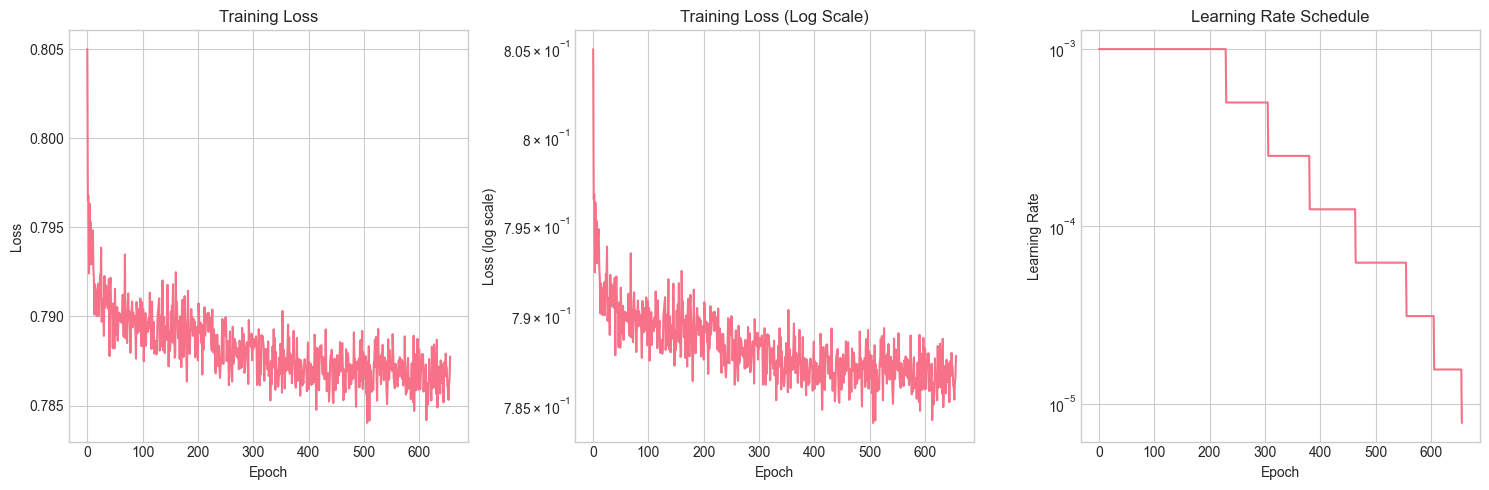

In [26]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 3, 2)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss (Log Scale)')

plt.subplot(1, 3, 3)
plt.plot(lr_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.tight_layout()
plt.show()
# Training Hisotry plots

In [27]:
# Save training history
training_history = pd.DataFrame({
    'epoch': range(len(loss_history)),
    'loss': loss_history,
    'learning_rate': lr_history
})
training_history.to_csv('training_history.csv', index=False)
print("Training history saved!")

Training history saved!


## 5. Generate Synthetic Stellar Evolution Tracks


In [29]:
# Encode the real data to latent space
mean, log_var = vae.encode(X_train)
latent_representations = vae.reparameterize(mean, log_var).numpy()

# Generate new samples from the latent space
def generate_samples(n_samples):
    # Sample from the latent space
    z_samples = np.random.normal(size=(n_samples, latent_dim))
    
    # Decode to feature space
    generated_samples = vae.decode(z_samples).numpy()
    
    # Inverse transform to original scale
    generated_original = scaler.inverse_transform(generated_samples)
    
    return pd.DataFrame(generated_original, columns=features)

# Generate synthetic stars
n_samples = 1000000
synthetic_stars = generate_samples(n_samples)

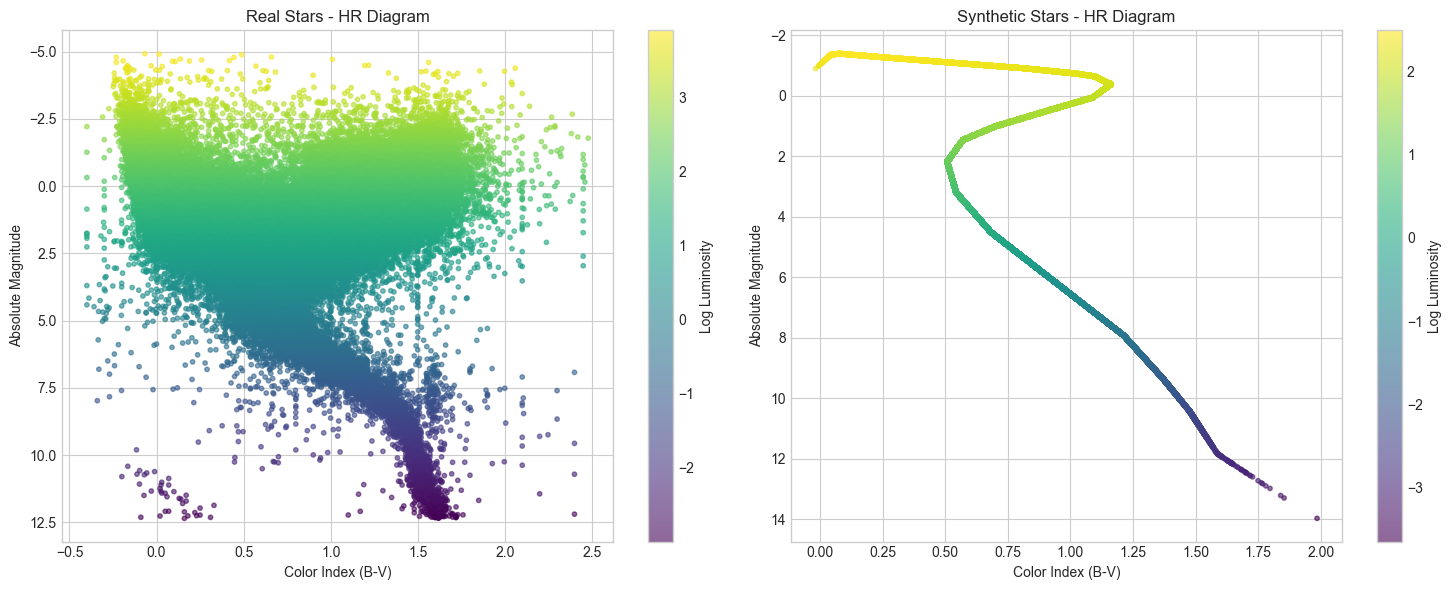

In [30]:
# Compare real and synthetic data in HR diagram
plt.figure(figsize=(15, 6))

# Real data
plt.subplot(1, 2, 1)
plt.scatter(df_features['ci'], df_features['absmag'], 
            alpha=0.6, s=10, c=df_features['log_lum'], cmap='viridis')
plt.colorbar(label='Log Luminosity')
plt.xlabel('Color Index (B-V)')
plt.ylabel('Absolute Magnitude')
plt.title('Real Stars - HR Diagram')
plt.gca().invert_yaxis()

# Synthetic data
plt.subplot(1, 2, 2)
plt.scatter(synthetic_stars['ci'], synthetic_stars['absmag'], 
            alpha=0.6, s=10, c=synthetic_stars['log_lum'], cmap='viridis')
plt.colorbar(label='Log Luminosity')
plt.xlabel('Color Index (B-V)')
plt.ylabel('Absolute Magnitude')
plt.title('Synthetic Stars - HR Diagram')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
# Real Stars - HR Diagram vs Synthetic Stars - HR Diagram

## 6. Generate Stellar Evolution Tracks

In [31]:
def generate_evolution_track(initial_z, target_z=None, steps=50, temperature=0.01):
    """Generate a smooth stellar evolution track by interpolating in latent space"""
    if target_z is None:
        # Create a small random walk with very low temperature
        z_path = [initial_z.squeeze(axis=0)]
        for i in range(1, steps):
            noise = np.random.normal(scale=temperature, size=initial_z.shape)
            z_path.append((initial_z + noise).squeeze(axis=0))
    else:
        # Linear interpolation between initial and target points
        z_path = []
        for i in range(steps):
            alpha = i / (steps - 1)
            z_point = (1 - alpha) * initial_z + alpha * target_z
            z_path.append(z_point.squeeze(axis=0))
    
    z_path = np.array(z_path)
    
    # Decode to feature space
    evolution_track = vae.decode(z_path).numpy()
    
    # Inverse transform to original scale
    evolution_original = scaler.inverse_transform(evolution_track)
    
    return pd.DataFrame(evolution_original, columns=features)

# Select better starting points and add target points for meaningful evolution
# Main sequence -> Red giant evolution
main_sequence_start = latent_representations[np.argmin(np.abs(df_features['absmag'] - 5))].reshape(1, -1)
red_giant_target = latent_representations[np.argmin(np.abs(df_features['absmag'] + 0.5))].reshape(1, -1)

# Main sequence -> White dwarf evolution  
main_sequence_start_wd = latent_representations[np.argmin(np.abs(df_features['absmag'] - 4))].reshape(1, -1)
white_dwarf_target = latent_representations[np.argmin(np.abs(df_features['absmag'] - 11))].reshape(1, -1)

# Generate meaningful evolution tracks
main_sequence_to_giant = generate_evolution_track(main_sequence_start, red_giant_target, steps=100, temperature=0.001)
main_sequence_to_wd = generate_evolution_track(main_sequence_start_wd, white_dwarf_target, steps=100, temperature=0.001)

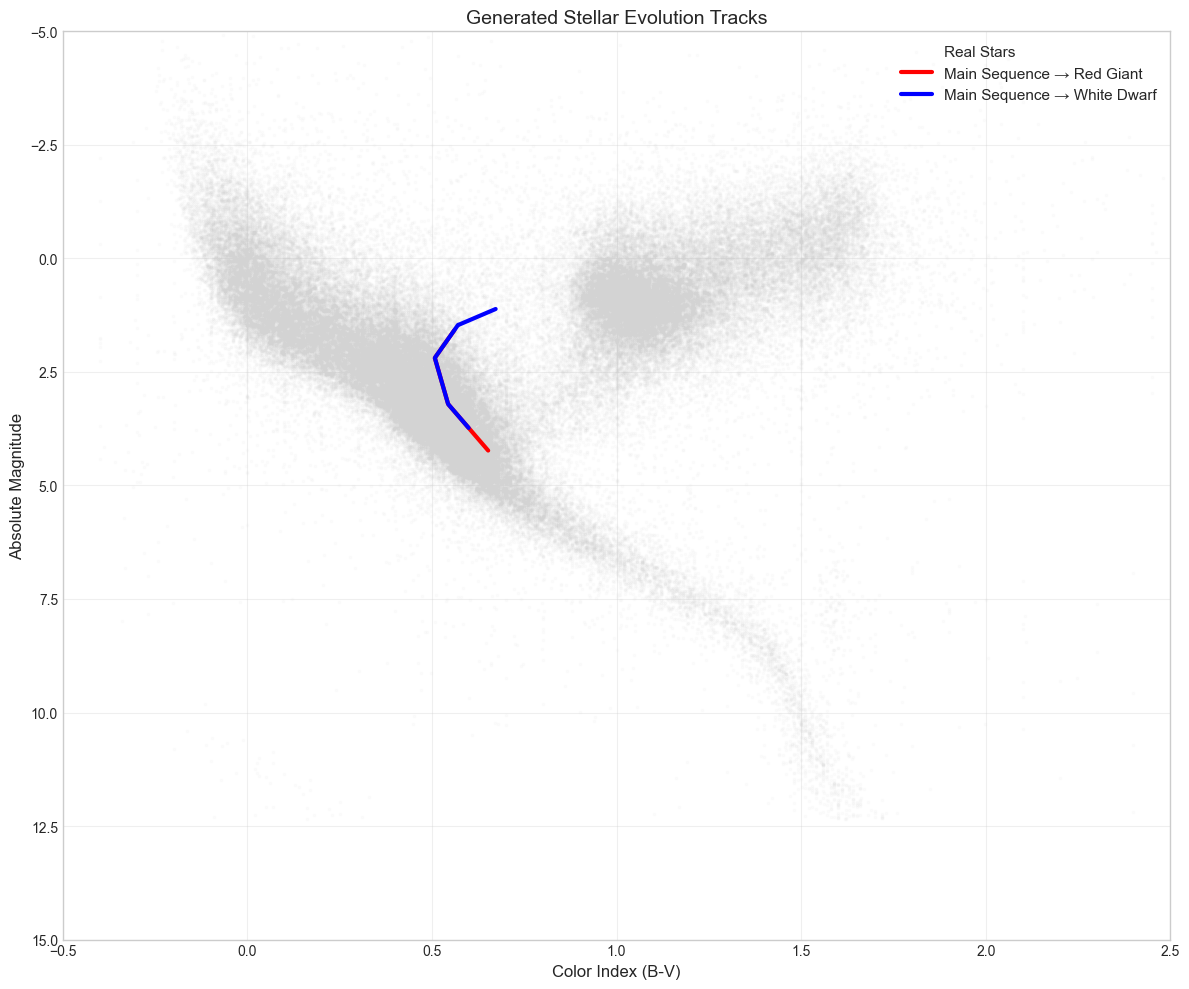

In [32]:
# Plot the evolution tracks with better styling
plt.figure(figsize=(12, 10))

# Background real stars (more transparent)
plt.scatter(df_features['ci'], df_features['absmag'], 
            alpha=0.05, s=3, c='lightgray', label='Real Stars')

# Evolution tracks - thicker lines, no markers, distinct colors
plt.plot(main_sequence_to_giant['ci'], main_sequence_to_giant['absmag'], 
         '-', linewidth=3, color='red', label='Main Sequence → Red Giant')
plt.plot(main_sequence_to_wd['ci'], main_sequence_to_wd['absmag'], 
         '-', linewidth=3, color='blue', label='Main Sequence → White Dwarf')

plt.xlabel('Color Index (B-V)', fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=12)
plt.title('Generated Stellar Evolution Tracks', fontsize=14)
plt.gca().invert_yaxis()

# Add grid and better legend
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=11)

# Set reasonable axis limits
plt.xlim(-0.5, 2.5)
plt.ylim(15, -5)  # Inverted for magnitude

plt.tight_layout()
plt.show()

## 7. Evaluate Model Performance


In [33]:
# Reconstruct some real stars to evaluate the model
def reconstruct_stars(star_indices):
    original_stars = df_features.iloc[star_indices]
    scaled_stars = scaler.transform(original_stars)
    
    reconstructed_stars = vae(scaled_stars)[0].numpy()
    reconstructed_original = scaler.inverse_transform(reconstructed_stars)
    
    return pd.DataFrame(reconstructed_original, columns=features), original_stars

# Select some example stars
example_indices = [10, 100, 500]  # Random indices
reconstructed, original = reconstruct_stars(example_indices)

# Compare original and reconstructed
for i, idx in enumerate(example_indices):
    print(f"Star {i+1}:")
    print(f"  Original: CI={original.iloc[i]['ci']:.2f}, M={original.iloc[i]['absmag']:.2f}")
    print(f"  Reconstructed: CI={reconstructed.iloc[i]['ci']:.2f}, M={reconstructed.iloc[i]['absmag']:.2f}")
    print()

Star 1:
  Original: CI=0.49, M=3.76
  Reconstructed: CI=0.55, M=3.31

Star 2:
  Original: CI=0.39, M=1.04
  Reconstructed: CI=0.54, M=3.12

Star 3:
  Original: CI=0.59, M=1.57
  Reconstructed: CI=0.52, M=2.07



In [34]:
# Calculate reconstruction error
reconstruction_errors = []
for i in tqdm(range(len(df_features))):
    original_star = df_features.iloc[i:i+1]
    scaled_star = scaler.transform(original_star)
    
    reconstructed_star = vae(scaled_star)[0].numpy()
    reconstructed_original = scaler.inverse_transform(reconstructed_star)
    
    error = np.mean(np.abs(original_star.values - reconstructed_original))
    reconstruction_errors.append(error)

print(f"Mean reconstruction error: {np.mean(reconstruction_errors):.4f}")
print(f"Max reconstruction error: {np.max(reconstruction_errors):.4f}")

100%|██████████| 107368/107368 [23:37<00:00, 75.76it/s]

Mean reconstruction error: 24.1286
Max reconstruction error: 173.2640


In [35]:
reconstruction_errors = pd.DataFrame({'Mean reconstruction error': [f'{np.mean(reconstruction_errors):.4f}'], 'Max reconstruction error': [f"{np.max(reconstruction_errors):.4f}"],'min reconstruction error': [f"{np.min(reconstruction_errors):.4f}"]}).to_csv('reconstruction_errors.csv', index=False)

## 8. Advanced Analysis: Cluster-Based Generation


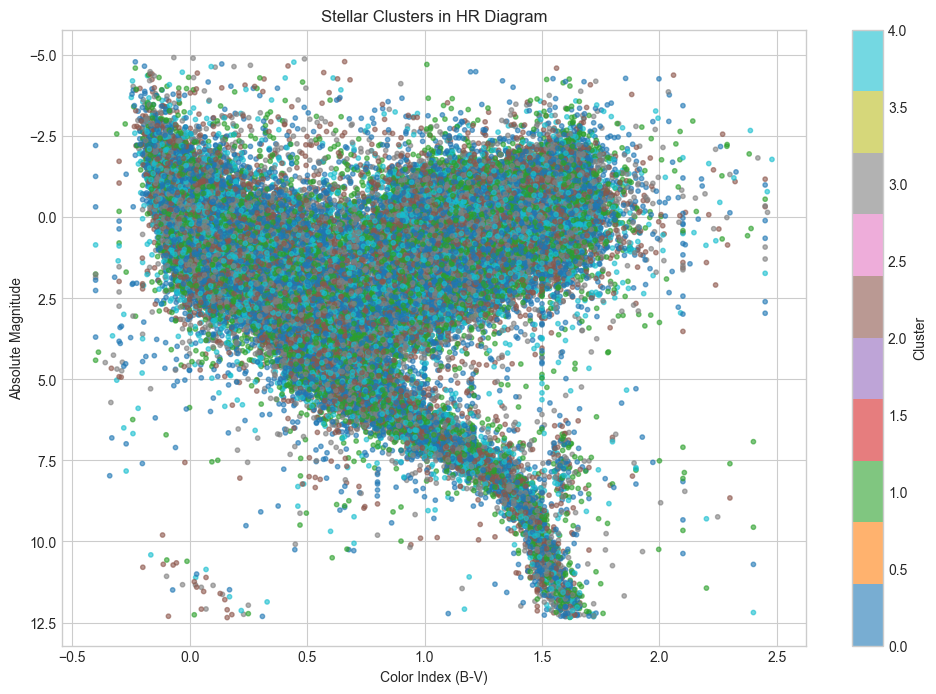

In [36]:
from sklearn.cluster import KMeans

# Cluster stars in the latent space
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_representations)

# Visualize clusters in the HR diagram
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_features['ci'], df_features['absmag'], 
                      c=clusters, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Color Index (B-V)')
plt.ylabel('Absolute Magnitude')
plt.title('Stellar Clusters in HR Diagram')
plt.gca().invert_yaxis()
plt.show()

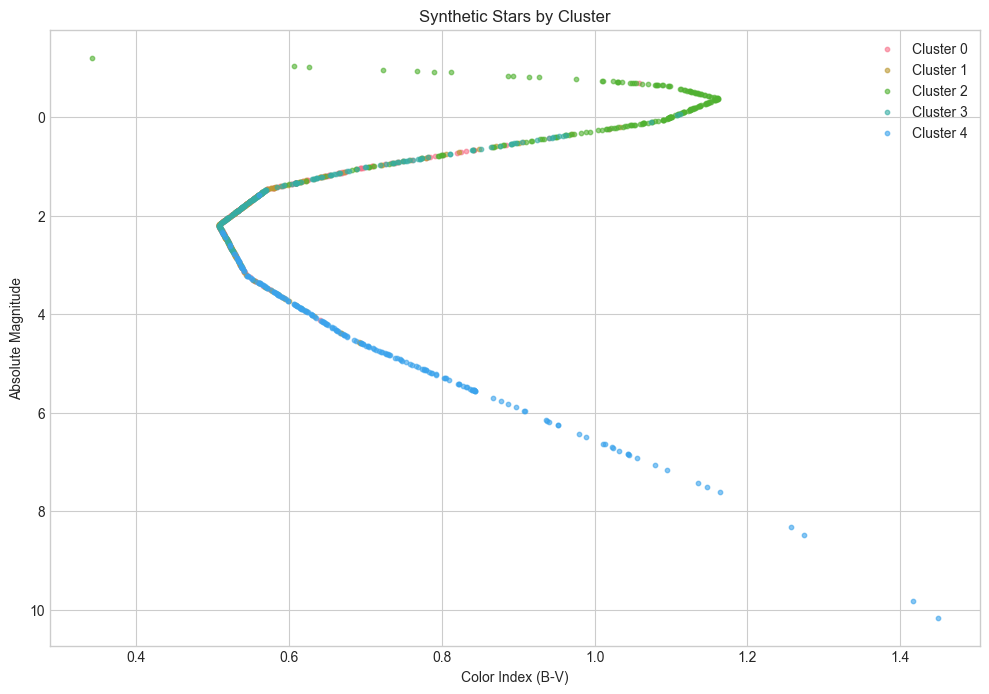

In [37]:
# Generate samples from each cluster
cluster_samples = {}
for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_latent = latent_representations[cluster_mask]
    
    # Calculate cluster center
    cluster_center = np.mean(cluster_latent, axis=0)
    
    # Generate samples around the center
    n_samples_per_cluster = 200
    cluster_z = cluster_center + np.random.normal(scale=0.5, size=(n_samples_per_cluster, latent_dim))
    
    # Decode samples
    cluster_features = vae.decode(cluster_z).numpy()
    cluster_original = scaler.inverse_transform(cluster_features)
    
    cluster_samples[cluster_id] = pd.DataFrame(cluster_original, columns=features)

# Plot generated samples by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(n_clusters):
    samples = cluster_samples[cluster_id]
    plt.scatter(samples['ci'], samples['absmag'], 
                alpha=0.6, s=10, label=f'Cluster {cluster_id}')

plt.xlabel('Color Index (B-V)')
plt.ylabel('Absolute Magnitude')
plt.title('Synthetic Stars by Cluster')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## 9. Save Model and Results


In [38]:
# Save the trained VAE model
vae.save_weights('stellar_vae_weights.weights.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

# Save generated evolution tracks
evolution_tracks = {
    'main_sequence_to_giant': main_sequence_to_giant,
    'main_sequence_to_wd': main_sequence_to_wd
}

for name, track in evolution_tracks.items():
    track.to_csv(f'{name}_evolution_track.csv', index=False)

# Also save the training history and reconstruction errors
training_history = pd.DataFrame({
    'epoch': range(len(loss_history)),
    'loss': loss_history,
    'learning_rate': lr_history
})
training_history.to_csv('training_history.csv', index=False)

# Save latent space representations
np.save('latent_representations.npy', latent_representations)

# Save model architecture information
model_info = {
    'latent_dim': latent_dim,
    'input_dim': input_dim,
    'features': features,
    'training_samples': len(X_train)
}
import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("Model and all results saved successfully!")
print("Saved files:")
print("- stellar_vae_weights.weights.h5 (model weights)")
print("- scaler.pkl (feature scaler)")
print("- main_sequence_to_giant_evolution_track.csv")
print("- main_sequence_to_wd_evolution_track.csv")
print("- training_history.csv")
print("- latent_representations.npy")
print("- model_info.json")

Model and all results saved successfully!
Saved files:
- stellar_vae_weights.weights.h5 (model weights)
- scaler.pkl (feature scaler)
- main_sequence_to_giant_evolution_track.csv
- main_sequence_to_wd_evolution_track.csv
- training_history.csv
- latent_representations.npy
- model_info.json
